In [1]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import string
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    precision_score
)
from sklearn.utils import resample
from scipy.stats import skew
from scipy import stats

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from lime.lime_tabular import LimeTabularExplainer

from surrogate_functions import print_evaluation_metrics, plot_odds_ratio, plot_most_important_features, PLTR, get_data_step1

/opt/homebrew/Caskroom/miniforge/base/envs/credit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Exploratory Data Analysis

In [2]:
df = pd.read_csv("dataproject2025.csv", index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1086236 entries, 0 to 1086682
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   issue_d                  1086236 non-null  int64  
 1   loan duration            1086236 non-null  int64  
 2   annual_inc               1086236 non-null  float64
 3   avg_cur_bal              1086236 non-null  float64
 4   bc_open_to_buy           1086236 non-null  float64
 5   bc_util                  1086236 non-null  float64
 6   delinq_2yrs              1086236 non-null  float64
 7   dti                      1086236 non-null  float64
 8   emp_length               1086236 non-null  object 
 9   emp_title                1086236 non-null  object 
 10  fico_range_high          1086236 non-null  float64
 11  funded_amnt              1086236 non-null  float64
 12  grade                    1086236 non-null  object 
 13  home_ownership           1086236 non-null  obje

In [4]:
# Checking the performance of the given predictions

y_true = df["target"]
y_pred = df["Predictions"]

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85    857588
           1       0.41      0.37      0.39    228648

    accuracy                           0.75   1086236
   macro avg       0.62      0.61      0.62   1086236
weighted avg       0.75      0.75      0.75   1086236



In [5]:
df.drop(columns=["Predictions", "Predicted probabilities"], inplace=True) # already given predictions and probabilities

In [6]:
df.head()

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,...,0.0,0.0,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,...,0.0,0.0,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456
2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,...,0.0,0.0,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862
3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,...,0.0,0.0,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132
4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,...,0.0,0.0,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900


In [7]:
na_rows = df.isna().any(axis=1)
print(f"Number of rows with NA: {na_rows.sum()}")
display(df[na_rows])

print(df.isna().sum(axis=1).value_counts())

Number of rows with NA: 0


,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american


0    1086236
Name: count, dtype: int64


In [8]:
# ProfileReport(df)

In [9]:
df_dropped = df.dropna(axis=0)  # either y misses or all X miss

In [10]:
def analyze_preprocessing_needs(df, variables=None):
    """
    Analyze variable distributions to determine optimal preprocessing strategy.
    Returns recommendations for log transformation vs outlier capping.
    """
    
    if variables is None:
        variables = ['annual_inc', 'dti', 'revol_bal', 'revol_util', 'funded_amnt', 
                    'avg_cur_bal', 'open_acc', 'fico_range_high', 'inq_last_6mths']
    
    variables = [var for var in variables if var in df.columns]
    
    recommendations = {'LOG_TRANSFORM': [], 'CAP_OUTLIERS': [], 'NO_PREPROCESSING': []}
    
    print("PREPROCESSING ANALYSIS")
    print("=" * 50)
    
    for var in variables:
        data = df[var].dropna()
        if len(data) == 0 or df[var].dtype not in ['int64', 'float64']:
            continue
            
        # Key metrics
        skewness = skew(data)
        outliers_pct = (np.abs(stats.zscore(data)) > 3).sum() / len(data) * 100
        tail_ratio = data.quantile(0.99) / data.median() if data.median() > 0 else 0
        
        # Decision logic
        if skewness > 1.5 and tail_ratio > 5 and data.min() >= 0:
            rec = "LOG_TRANSFORM"
            reason = f"Highly skewed ({skewness:.2f}), long tail ({tail_ratio:.1f}x)"
        elif outliers_pct > 1.0:
            rec = "CAP_OUTLIERS" 
            reason = f"Normal distribution with {outliers_pct:.1f}% outliers"
        else:
            rec = "NO_PREPROCESSING"
            reason = f"Normal distribution (skew: {skewness:.2f})"
            
        recommendations[rec].append(var)
        print(f"{var:15} | {rec:15} | {reason}")
    
    print("\n" + "=" * 50)
    print("FINAL PREPROCESSING STRATEGY")
    print("=" * 50)
    
    for strategy, vars_list in recommendations.items():
        if vars_list:
            print(f"\n{strategy}: {vars_list}")
    
    return recommendations

preprocessing_strategy = analyze_preprocessing_needs(df_dropped)

PREPROCESSING ANALYSIS
annual_inc      | CAP_OUTLIERS    | Normal distribution with 1.5% outliers
dti             | NO_PREPROCESSING | Normal distribution (skew: 0.21)
revol_bal       | LOG_TRANSFORM   | Highly skewed (6.49), long tail (9.0x)
revol_util      | NO_PREPROCESSING | Normal distribution (skew: -0.11)
funded_amnt     | NO_PREPROCESSING | Normal distribution (skew: 0.62)
avg_cur_bal     | LOG_TRANSFORM   | Highly skewed (3.50), long tail (10.3x)
open_acc        | CAP_OUTLIERS    | Normal distribution with 1.3% outliers
fico_range_high | CAP_OUTLIERS    | Normal distribution with 1.6% outliers
inq_last_6mths  | CAP_OUTLIERS    | Normal distribution with 1.6% outliers

FINAL PREPROCESSING STRATEGY

LOG_TRANSFORM: ['revol_bal', 'avg_cur_bal']

CAP_OUTLIERS: ['annual_inc', 'open_acc', 'fico_range_high', 'inq_last_6mths']

NO_PREPROCESSING: ['dti', 'revol_util', 'funded_amnt']


In [11]:
def get_features(df: pd.DataFrame()) -> pd.DataFrame():
    """
    Get additional features.
    """

    df_with_features = df.assign(
        # Log transformations - reduce skewness in monetary values
        avg_cur_bal_log=np.log1p(df["avg_cur_bal"]),
        revol_bal_log=np.log1p(df["revol_bal"]),
        
        # Derived financial metrics
        cur_balance=df["avg_cur_bal"] * df["open_acc"],  # Total credit exposure across all accounts
        
        # Binary risk flags
        delinq_2yrs_flag=df["delinq_2yrs"] >= 1,  # Any recent delinquency is a strong risk signal
        tax_liens_flag=df["tax_liens"] >= 1,  # Tax problems indicate financial distress
        
        # Credit portfolio composition ratios
        s_actv_bc_tl=df["num_actv_bc_tl"] / (df["open_acc"] + 1e-6),  # Share of active bank cards vs total accounts
        s_bc_tl=df["num_bc_tl"] / (df["open_acc"] + 1e-6),  # Bank card concentration in credit profile
        s_il_tl=df["num_il_tl"] / (df["open_acc"] + 1e-6),  # Installment loan dependency ratio
        s_rev_accts=df["num_rev_accts"] / (df["open_acc"] + 1e-6),  # Revolving credit reliance measure
        
        # Risk interaction features
        revol_bal_income_ratio=df["revol_bal"]
        / (df["annual_inc"] + 1e-6),  # Credit card debt relative to earning capacity
    )

    df_with_features.drop(columns=["revol_bal", "avg_cur_bal"], inplace=True)
    return df_with_features


df_engineered = get_features(df_dropped)

In [12]:
cap_variables = ["annual_inc", "open_acc", "fico_range_high", "inq_last_6mths"]

for var in cap_variables:
    if var in df_engineered.columns:
        # Z-score method
        z_scores = np.abs(stats.zscore(df_engineered[var].dropna()))
        outliers = df_engineered[z_scores > 3]

        # Compare default rates
        outlier_default_rate = outliers["target"].mean()
        normal_default_rate = df_engineered[z_scores <= 3]["target"].mean()

        print(f"{var} outliers (>{3} std): {len(outliers)} samples")
        print(f"  Outlier default rate: {outlier_default_rate:.4f}")
        print(f"  Normal default rate: {normal_default_rate:.4f}")

annual_inc outliers (>3 std): 16606 samples
  Outlier default rate: 0.1267
  Normal default rate: 0.2118
open_acc outliers (>3 std): 14456 samples
  Outlier default rate: 0.2473
  Normal default rate: 0.2100
fico_range_high outliers (>3 std): 17625 samples
  Outlier default rate: 0.0833
  Normal default rate: 0.2126
inq_last_6mths outliers (>3 std): 16945 samples
  Outlier default rate: 0.2761
  Normal default rate: 0.2095


In [13]:
# Cap outliers at 99th percentile rather than removing (preserves business insight)
def cap_outliers(df, columns, percentile=99):
    df_capped = df.copy()

    for col in columns:
        if col in df_capped.columns:
            upper_bound = df_capped[col].quantile(percentile / 100)
            lower_bound = df_capped[col].quantile((100 - percentile) / 100)

            original_outliers = (
                (df_capped[col] > upper_bound) | (df_capped[col] < lower_bound)
            ).sum()

            df_capped[col] = df_capped[col].clip(lower=lower_bound, upper=upper_bound)
            print(f"{col}: Capped {original_outliers} outliers")

    return df_capped

df_engineered = cap_outliers(df_engineered, cap_variables, percentile=99)

annual_inc: Capped 19499 outliers
open_acc: Capped 13381 outliers
fico_range_high: Capped 8784 outliers
inq_last_6mths: Capped 4984 outliers


In [14]:
# Check for logical inconsistencies
# Check if employment length makes sense with age-related features
if "emp_length_num" in df_engineered.columns:
    unrealistic_emp = df_engineered[
        df_engineered["emp_length_num"] > 50
    ]  # >50 years employment
    print(f"Unrealistic employment length: {len(unrealistic_emp)} cases")

# Check for negative values where they shouldn't exist
numeric_cols = df_engineered.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col not in ["target", "issue_d"]:  # Skip target and year
        negative_count = (df_engineered[col] < 0).sum()
        if negative_count > 0:
            print(f"{col}: {negative_count} negative values")

# Check for extreme DTI ratios
extreme_dti = df_engineered[df_engineered["dti"] > 100]
if len(extreme_dti) > 0:
    print(
        f"Extreme DTI (>100%): {len(extreme_dti)} cases, default rate: {extreme_dti['target'].mean():.4f}"
    )

dti: 1 negative values


In [15]:
# Fix the negative DTI value
df_engineered["dti"] = df_engineered["dti"].clip(lower=0)

In [16]:
# Analyze zip code patterns
zip_analysis = (
    df_engineered.groupby("zip_code")
    .agg(
        {"target": ["mean", "count"], "annual_inc": "mean", "Pct_afro_american": "mean"}
    )
    .round(4)
)

zip_analysis.columns = ["default_rate", "loan_count", "avg_income", "pct_afro_american"]
zip_analysis = zip_analysis[
    zip_analysis["loan_count"] >= 100
]  # Filter for sufficient samples

# Identify high-risk zip codes
high_risk_zips = zip_analysis[
    zip_analysis["default_rate"] > zip_analysis["default_rate"].quantile(0.9)
]
print("High-risk ZIP codes (top 10%):")
print(high_risk_zips.head(10))

High-risk ZIP codes (top 10%):
          default_rate  loan_count  avg_income  pct_afro_american
zip_code                                                         
12              0.2600         400  66981.1149             2.7267
82              0.2578        1024  78540.9078             9.4810
83              0.2642         916  68251.3445            16.5842
84              0.3040         125  66757.1789            23.3300
89              0.2683         410  90480.3597            17.2322
104             0.2822        8017  64552.1991            34.7217
114             0.2577        4672  70578.8895            39.0090
116             0.2739         555  77612.9552            37.5146
118             0.2562         320  97072.3688             1.1509
126             0.2844         327  78287.6807            19.9090


In [17]:
# Create ZIP-based risk tiers instead of using individual ZIP codes
zip_risk = df_engineered.groupby("zip_code")["target"].agg(["mean", "count"])
zip_risk = zip_risk[zip_risk["count"] >= 50]  # Minimum sample size

# Create risk tiers
zip_risk["risk_tier"] = pd.qcut(
    zip_risk["mean"], q=5, labels=["Low", "Low-Med", "Medium", "Med-High", "High"]
)

# Map back to main dataset
zip_risk_map = zip_risk["risk_tier"].to_dict()
df_engineered["zip_risk_tier"] = (
    df_engineered["zip_code"].map(zip_risk_map).fillna("Medium")
)

# Create dummy variables and remove the original object column
df_engineered = pd.get_dummies(
    df_engineered, columns=["zip_risk_tier"], prefix="zip_risk", drop_first=True
)

df_engineered.drop(columns=["zip_code"], inplace=True)


Default rates by issue year:
         default_rate  loan_count
issue_d                          
2012           0.1770       14324
2013           0.1687       86574
2014           0.1941      152117
2015           0.2142      271416
2016           0.2101      258793
2017           0.2267      173921
2018           0.2563       94893
2019           0.1761       32368
2020           0.0066        1830


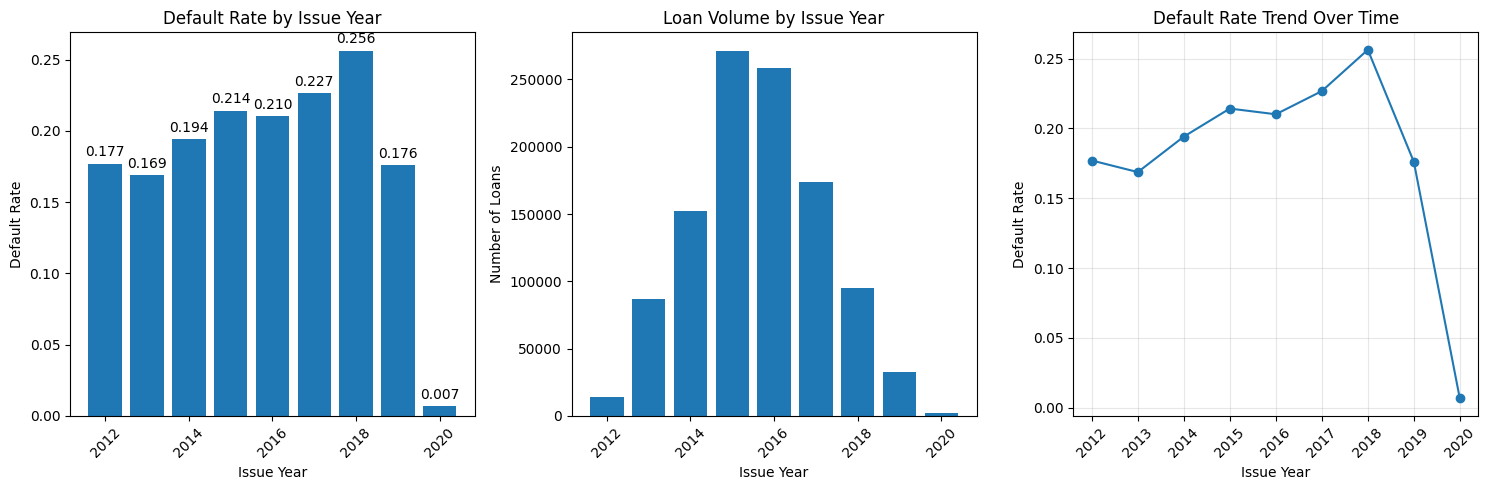

In [18]:
# Calculate default rate by year
default_by_year = (
    df_engineered.groupby("issue_d")["target"].agg(["mean", "count"]).round(4)
)
default_by_year.columns = ["default_rate", "loan_count"]
print("\nDefault rates by issue year:")
print(default_by_year)

# Visualizations
plt.figure(figsize=(15, 5))

# Plot 1: Default rate by year
plt.subplot(1, 3, 1)
plt.bar(default_by_year.index, default_by_year["default_rate"])
plt.xlabel("Issue Year")
plt.ylabel("Default Rate")
plt.title("Default Rate by Issue Year")
plt.xticks(rotation=45)
for i, v in enumerate(default_by_year["default_rate"]):
    plt.text(default_by_year.index[i], v + 0.005, f"{v:.3f}", ha="center")

# Plot 2: Loan count by year
plt.subplot(1, 3, 2)
plt.bar(default_by_year.index, default_by_year["loan_count"])
plt.xlabel("Issue Year")
plt.ylabel("Number of Loans")
plt.title("Loan Volume by Issue Year")
plt.xticks(rotation=45)


# Plot 3: Time series trend
plt.subplot(1, 3, 3)
plt.plot(default_by_year.index, default_by_year["default_rate"], "o-")
plt.xlabel("Issue Year")
plt.ylabel("Default Rate")
plt.title("Default Rate Trend Over Time")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [19]:
# import numpy as np
# import pandas as pd
# from scipy import stats
# from scipy.stats import chi2

# def cochran_armitage_test(df, year_col='issue_d', target_col='target'):
#     """Cochran-Armitage trend test - returns test statistic and p-value"""
#     contingency = pd.crosstab(df[year_col], df[target_col])
#     years = contingency.index.values
#     n_defaults = contingency[1].values
#     n_total = contingency.sum(axis=1).values
    
#     scores = years.astype(float)
#     R = np.sum(n_defaults)
#     N = np.sum(n_total)
    
#     score_sum = np.sum(scores * n_total)
#     score_weighted_mean = score_sum / N
    
#     numerator_sum = np.sum(scores * n_defaults)
#     numerator = numerator_sum - R * score_weighted_mean
    
#     score_variance = np.sum(n_total * (scores - score_weighted_mean)**2) / N
#     variance = R * (N - R) * score_variance / N
    
#     if variance > 0:
#         test_statistic = (numerator**2) / variance
#         p_value = 1 - chi2.cdf(test_statistic, df=1)
#     else:
#         test_statistic = 0
#         p_value = 1
    
#     return test_statistic, p_value

# def run_temporal_tests(df, exclude_2020=True):
#     """Run all temporal tests and return results"""
    
#     if exclude_2020:
#         df_test = df[df['issue_d'] != 2020].copy()
#     else:
#         df_test = df.copy()
    
#     # Cochran-Armitage test
#     ca_stat, ca_p = cochran_armitage_test(df_test)
    
#     # Spearman correlation
#     spear_corr, spear_p = stats.spearmanr(df_test['issue_d'], df_test['target'])
    
#     # Pearson for comparison
#     pearson_corr = df_test['issue_d'].corr(df_test['target'])
    
#     return {
#         'sample_size': len(df_test),
#         'cochran_armitage_stat': ca_stat,
#         'cochran_armitage_p': ca_p,
#         'spearman_corr': spear_corr,
#         'spearman_p': spear_p,
#         'pearson_corr': pearson_corr
#     }

# # Run tests
# results_no_2020 = run_temporal_tests(df_engineered, exclude_2020=True)
# results_with_2020 = run_temporal_tests(df_engineered, exclude_2020=False)

# print("Without 2020:")
# print(results_no_2020)
# print("\nWith 2020:")
# print(results_with_2020)

In [20]:
# Since grade and sub_grade are highly important, analyze their consistency
grade_subgrade_analysis = (
    df_engineered.groupby(["grade", "sub_grade"])
    .agg({"target": ["mean", "count"], "int_rate": "mean"})
    .round(4)
)

print("Grade/Sub-grade consistency check:")
print(grade_subgrade_analysis.head(20))

# Check if sub_grade adds value beyond grade
from sklearn.metrics import mutual_info_score

grade_info = mutual_info_score(df_engineered["target"], df_engineered["grade"])
subgrade_info = mutual_info_score(df_engineered["target"], df_engineered["sub_grade"])
print(f"Mutual information - Grade: {grade_info:.4f}, Sub-grade: {subgrade_info:.4f}")

Grade/Sub-grade consistency check:
                 target        int_rate
                   mean  count     mean
grade sub_grade                        
A     A1         0.0381  24903   5.6068
      A2         0.0490  21073   6.5859
      A3         0.0581  24299   7.1387
      A4         0.0721  35584   7.5503
      A5         0.0860  45887   8.1992
B     B1         0.1025  48455   8.9096
      B2         0.1154  52344   9.9106
      B3         0.1297  59496  10.6708
      B4         0.1485  67021  11.3904
      B5         0.1633  71332  11.9203
C     C1         0.1855  69769  12.7464
      C2         0.2050  66219  13.4595
      C3         0.2225  65957  14.0652
      C4         0.2459  68081  14.7883
      C5         0.2599  63009  15.6805
D     D1         0.2738  45134  16.5289
      D2         0.2939  40784  17.5712
      D3         0.3055  35090  18.2964
      D4         0.3229  32168  18.9502
      D5         0.3391  27252  19.9615
Mutual information - Grade: 0.0318, Sub-grade

In [21]:
# Analyze loan purpose risk
purpose_analysis = (
    df_engineered.groupby("purpose")
    .agg({"target": ["mean", "count"], "int_rate": "mean", "funded_amnt": "mean"})
    .round(4)
)

print("Risk by loan purpose:")
print(purpose_analysis.sort_values(("target", "mean"), ascending=False))

# Employment title risk (top employment categories)
emp_title_analysis = df_engineered.groupby("emp_title")["target"].agg(["mean", "count"])
emp_title_analysis = emp_title_analysis[emp_title_analysis["count"] >= 50]
print("\nRiskiest employment titles (min 50 samples):")
print(emp_title_analysis.sort_values("mean", ascending=False).head(15))

Risk by loan purpose:
                    target         int_rate funded_amnt
                      mean   count     mean        mean
purpose                                                
small_business      0.2942   13305  16.4728  16421.7681
house               0.2358    6977  15.5065  16369.7076
renewable_energy    0.2212     832  15.2019  10875.8413
debt_consolidation  0.2209  642348  14.2109  16702.8927
moving              0.2208    8643  14.8750   8578.5694
major_purchase      0.2177   21609  13.7239  14048.0587
medical             0.2172   11964  14.5383   9791.1986
other               0.2163   65701  15.0928  10835.1551
vacation            0.1957    7343  14.1286   6636.4020
home_improvement    0.1924   65653  13.5461  15997.5241
credit_card         0.1805  232282  12.3370  16457.6633
wedding             0.1726     481  18.1804  12717.2557
car                 0.1632    9098  13.2076  10004.7978

Riskiest employment titles (min 50 samples):
                                    

In [22]:
df_original_for_fairness = df_engineered.copy()
df_engineered.drop(columns=["Pct_afro_american"], inplace=True)

In [23]:
def categorical_encoding(df: pd.DataFrame) -> pd.DataFrame:
    """Improved categorical encoding."""

    df_encoded = df.copy()

    # Keep only sub_grade (more informative than grade)
    sg = df_encoded["sub_grade"].astype(str).str.upper().str.strip()
    letter = sg.str[0]
    number = pd.to_numeric(
        sg.str[1:].str.extract(r"(\d+)", expand=False), errors="coerce"
    )
    letter_map = {ch: i + 1 for i, ch in enumerate("ABCDEFG")}
    base = letter.map(letter_map)
    df_encoded["sub_grade_num"] = ((base - 1) * 5 + number).astype("float32")

    # Employment length to numeric
    emp_length_map = {
        "< 1 year": 0,
        "1 year": 1,
        "2 years": 2,
        "3 years": 3,
        "4 years": 4,
        "5 years": 5,
        "6 years": 6,
        "7 years": 7,
        "8 years": 8,
        "9 years": 9,
        "10+ years": 10,
    }
    df_encoded["emp_length_num"] = (
        df_encoded["emp_length"].map(emp_length_map).astype("float32")
    )

    # Handle employment title differently - keep only frequent ones
    emp_title_counts = df_encoded["emp_title"].value_counts()
    frequent_titles = emp_title_counts[
        emp_title_counts >= 100
    ].index.tolist()  # Minimum 100 occurrences

    # Create 'other' category for infrequent titles
    df_encoded["emp_title_grouped"] = df_encoded["emp_title"].apply(
        lambda x: x if x in frequent_titles else "other"
    )

    # One-hot encode with manageable number of features
    onehot_cols = ["home_ownership", "purpose", "emp_title_grouped"]
    df_encoded = pd.get_dummies(
        df_encoded, columns=onehot_cols, prefix=onehot_cols, drop_first=True
    )

    # drop_first = False. This prevents the emp_title dimensionality explosion while preserving the signal from frequent job categories

    # Drop originals
    df_encoded = df_encoded.drop(
        columns=["grade", "sub_grade", "emp_length", "emp_title"]
    )

    return df_encoded


df_encoded = categorical_encoding(df_engineered)

## STEP 1

In [24]:
X, y, y_proba = get_data_step1()

/Users/joaosilva/Current/HEC/Interpretability Stability and Algorithmic Fairness/explainable-credit-scoring/surrogate_functions.py:97: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.6876349  -1.6876349  -1.6876349  ...  0.89960459  0.89960459
  0.89960459]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_encoded.loc[:, numerical_existing] = StandardScaler().fit_transform(X_encoded[numerical_existing])
/Users/joaosilva/Current/HEC/Interpretability Stability and Algorithmic Fairness/explainable-credit-scoring/surrogate_functions.py:97: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.6377609  -0.6377609  -0.6377609  ... -0.6377609  -0.6377609
  1.56798575]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_encoded.loc[:, numerical_existing] = StandardScaler().

Two surrogate models will be implemented: Logistic Regression and PLTR

### Logistic Regression

In [25]:
logreg = LogisticRegression(max_iter=3000, random_state=56)
logreg.fit(X, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,56
,solver,'lbfgs'
,max_iter,3000
,multi_class,'deprecated'


In [26]:
surrogate_preds_proba = logreg.predict_proba(X)[:, 1] #probs of 1
surrogate_preds = logreg.predict(X)

### Evaluating the surrogate

In [27]:
print_evaluation_metrics(y, y_proba, surrogate_preds, surrogate_preds_proba)

AUC: 0.9838524429279828
Accuracy score: 0.9904293357981139
Confusion matrix: [[876344   4921]
 [  5475 199496]]
Mean squared error: 0.2929657351629936


### Interpreting the model

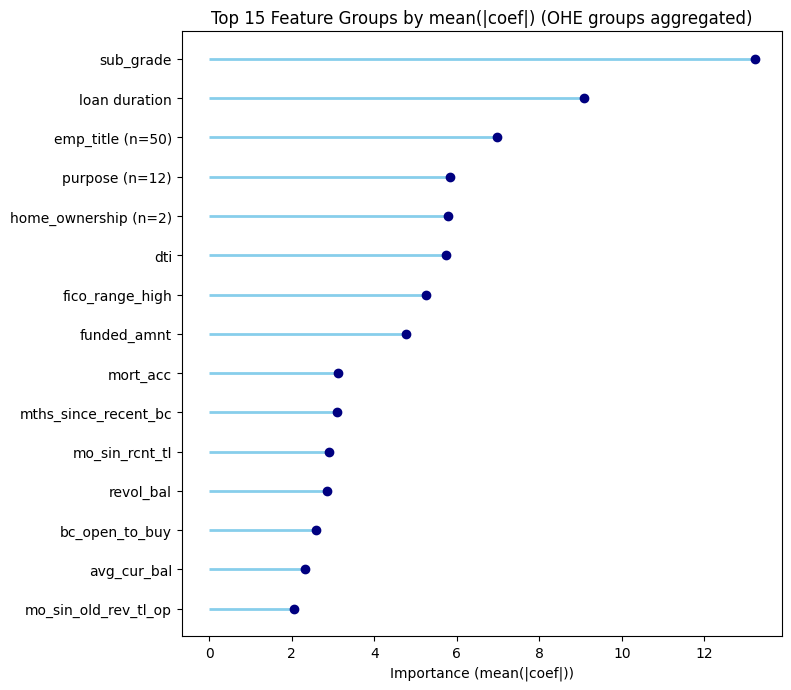

In [28]:
plot_most_important_features(logreg.coef_[0], X.columns)

This graph ranks features by their importance. To have a aggregate metric for each variable (one hot encoded categories belong to the same feature), we use the mean of the absolute values of the coefficients.

Most important: sb_grade, loan_duration, emp_title

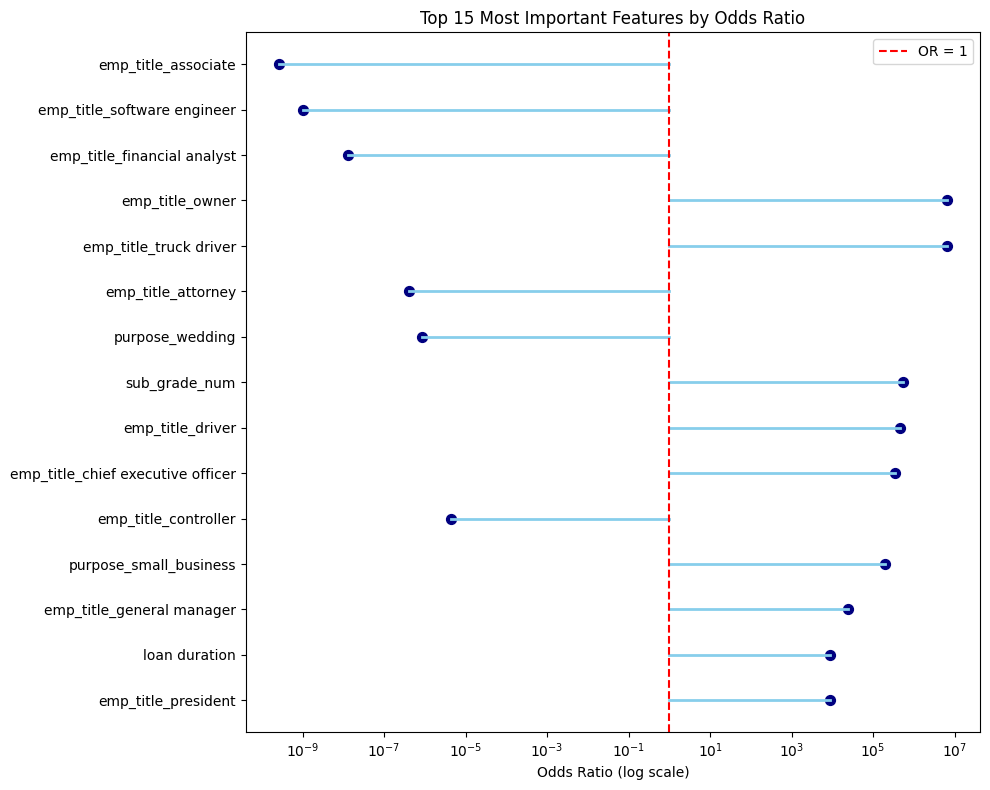

In [ ]:
plot_odds_ratio(logreg.coef_[0], X.columns)

### Custom PLTR

Custom implementation of PLTR

- Feature selection: Performed using a method inspired by random forests. For each decision tree, a subset of variables is omitted. The most frequently selected features across trees are then retained.

- Adaptive Lasso: The procedure begins by fitting a logistic regression with an L2 penalty. The resulting coefficients are used to compute feature weights. A second logistic regression is then fit with an L1 penalty, weighted by these coefficients, to achieve adaptive sparsity.

**Without Adpative Lasso**

In [30]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=5, feature_names=X.columns)
pltr.fit(X, y, adaptive_lasso=False)

,n_estimators,80
,max_depth,3
,random_state,5
,granularity,2
,k,5
,feature_names,Index(['issue...type='object')


In [31]:
pltr.modified_input_full

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,...,emp_title_technician,emp_title_truck driver,emp_title_vice president,sub_grade_num > 0.64,sub_grade_num < 0.64xloan duration > 0.47,sub_grade_num < 0.64xsub_grade_num > 0.17,sub_grade_num < 0.64xgrade_num > 1.26,grade_num > 0.48,grade_num < 0.48xloan duration > 0.47,sub_grade_num < 0.64xsub_grade_num > 1.27
0,-1.687635,-0.637761,-0.740512,-0.745082,0.749479,-1.586997,-0.370384,-1.880644,2.106130,-1.180039,...,False,False,False,0,0,0,0,0,0,0
1,-1.687635,-0.637761,-0.470965,-0.250508,0.416937,-0.242629,-0.370384,0.530276,1.258044,1.180387,...,False,False,False,0,0,0,0,0,0,0
2,-1.687635,-0.637761,4.254853,2.390279,0.248935,0.226833,-0.370384,0.019227,1.766896,1.281169,...,False,False,False,0,0,0,0,0,0,0
3,-1.687635,-0.637761,0.841762,1.367198,-0.426078,1.147974,-0.370384,-0.633779,0.749193,-0.416216,...,False,False,False,0,0,0,0,0,0,0
4,-1.687635,1.567986,-0.155910,0.630499,-0.342077,0.497129,0.729341,0.561034,-0.946979,1.238734,...,False,False,False,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086231,0.899605,1.567986,0.316671,0.886934,0.584482,-1.654571,-0.370384,-1.190965,-0.268510,2.023775,...,False,False,False,0,1,0,0,0,1,0
1086232,0.899605,1.567986,0.439193,-0.494564,0.703429,-1.234901,2.928791,-0.797031,-0.777361,0.856823,...,False,False,False,1,0,0,0,1,0,0
1086233,0.899605,-0.637761,-0.295935,-0.603490,1.054195,-1.284692,0.729341,0.137526,1.088427,-0.628389,...,False,False,False,0,0,0,0,0,0,0
1086234,0.899605,-0.637761,-0.716007,-0.630601,-0.159313,-1.963989,0.729341,0.189577,-0.777361,-1.052735,...,False,False,False,0,0,0,0,0,0,0


In [32]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [33]:
print_evaluation_metrics(y, y_proba, pltr_pred, pltr_pred_prob)

AUC: 0.9878704551455784
Accuracy score: 0.9928118751357901
Confusion matrix: [[877570   3695]
 [  4113 200858]]
Mean squared error: 0.2942495695086133


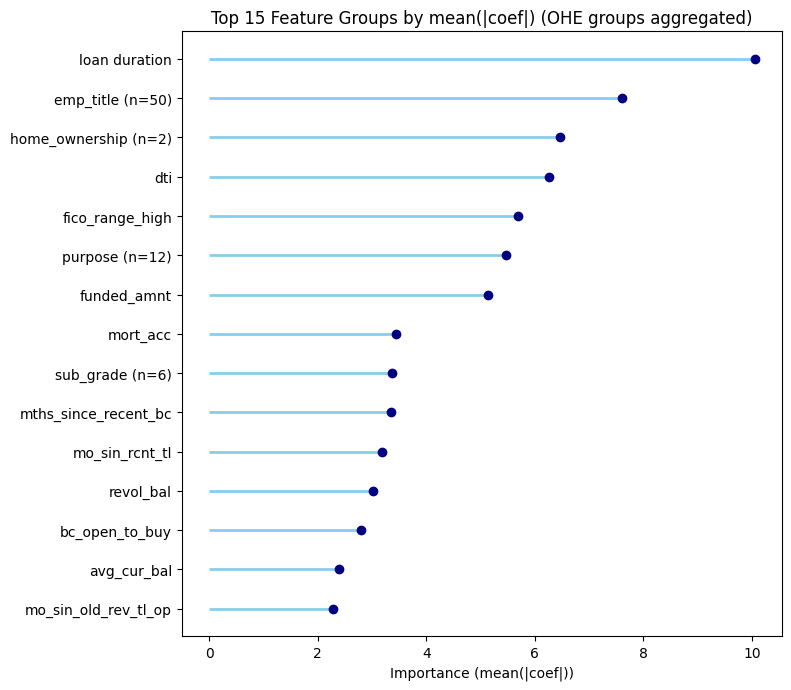

In [34]:
plot_most_important_features(pltr.pltr.coef_[0], pltr.modified_input_full.columns)

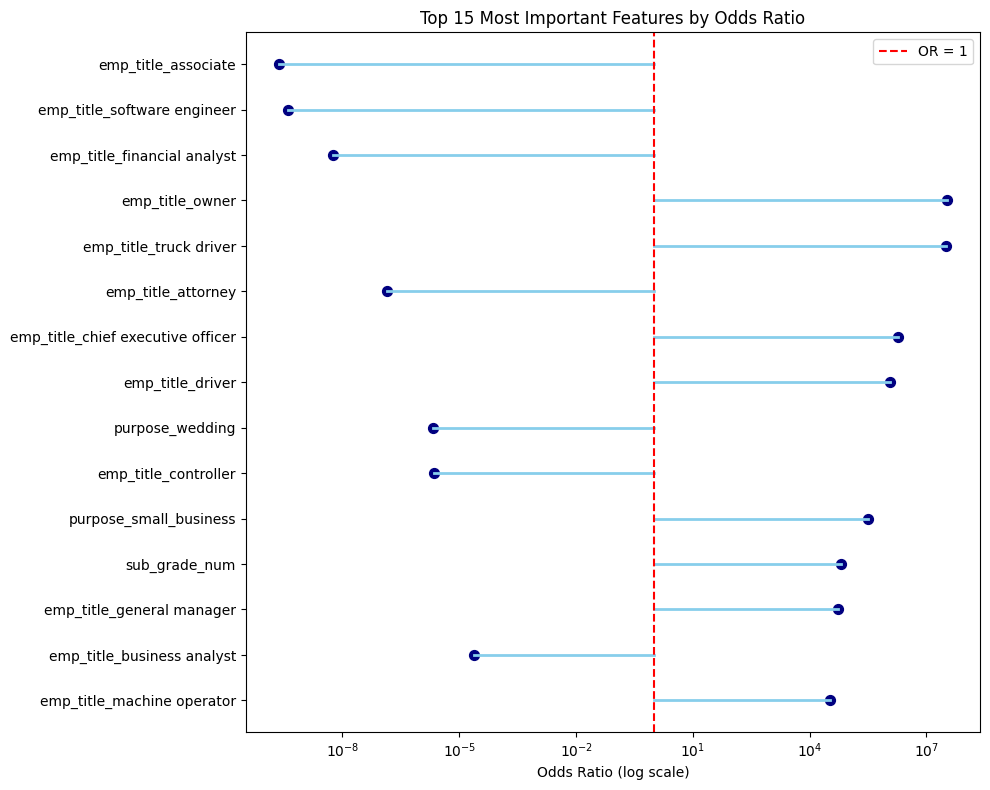

In [35]:
plot_odds_ratio(pltr.pltr.coef_[0], pltr.modified_input_full.columns)

**With Adaptive Lasso**

In [36]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=5, feature_names=X.columns)
pltr.fit(X, y, adaptive_lasso=True)

,n_estimators,80
,max_depth,3
,random_state,5
,granularity,2
,k,5
,feature_names,Index(['issue...type='object')


In [37]:
pltr.modified_input_full

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,...,emp_title_technician,emp_title_truck driver,emp_title_vice president,sub_grade_num > 0.64,sub_grade_num < 0.64xloan duration > 0.47,sub_grade_num < 0.64xsub_grade_num > 0.17,sub_grade_num < 0.64xgrade_num > 1.26,grade_num > 0.48,grade_num < 0.48xloan duration > 0.47,sub_grade_num < 0.64xsub_grade_num > 1.27
0,-0.060022,-6.497225,-1.280629,-1.823759,2.133978,-1.999176,-0.508858,-11.901377,12.087313,-6.117592,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0
1,-0.060022,-6.497225,-0.814479,-0.613175,1.187137,-0.305645,-0.508858,3.355775,7.220056,6.119394,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0
2,-0.060022,-6.497225,7.358274,5.850759,0.708787,0.285747,-0.508858,0.121678,10.140410,6.641872,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0
3,-0.060022,-6.497225,1.455730,3.346532,-1.213164,1.446129,-0.508858,-4.010780,4.299701,-2.157759,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0
4,-0.060022,15.973942,-0.269629,1.543292,-0.973990,0.626245,1.002017,3.550419,-5.434814,6.421881,...,0.0,0.0,0.0,5.622307,0.000000,0.0,0.0,0.228985,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086231,0.031995,15.973942,0.547647,2.170975,1.664184,-2.084301,-0.508858,-7.536844,-1.541008,10.491711,...,0.0,0.0,0.0,0.000000,0.085939,0.0,0.0,0.000000,0.05294,0.0
1086232,0.031995,15.973942,0.759533,-1.210560,2.002859,-1.555632,4.023767,-5.043894,-4.461363,4.441964,...,0.0,0.0,0.0,5.622307,0.000000,0.0,0.0,0.228985,0.00000,0.0
1086233,0.031995,-6.497225,-0.511784,-1.477181,3.001590,-1.618356,1.002017,0.870311,6.246604,-3.257712,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0
1086234,0.031995,-6.497225,-1.238251,-1.543541,-0.453608,-2.474082,1.002017,1.199710,-4.461363,-5.457620,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0


In [38]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [39]:
print_evaluation_metrics(y, y_proba, pltr_pred, pltr_pred_prob)

AUC: 0.9886760205437726
Accuracy score: 0.9931773574066778
Confusion matrix: [[877657   3608]
 [  3803 201168]]
Mean squared error: 0.2979236935020349


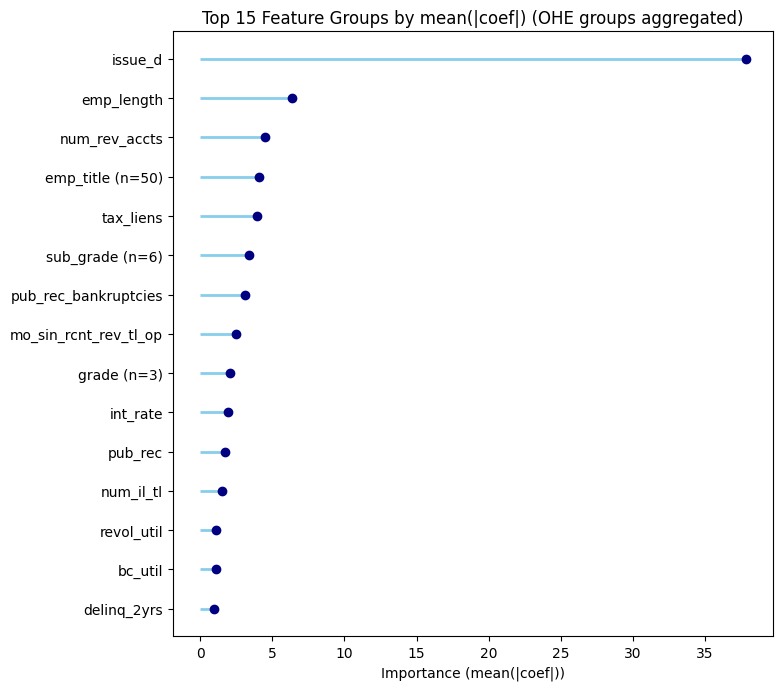

In [40]:
plot_most_important_features(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

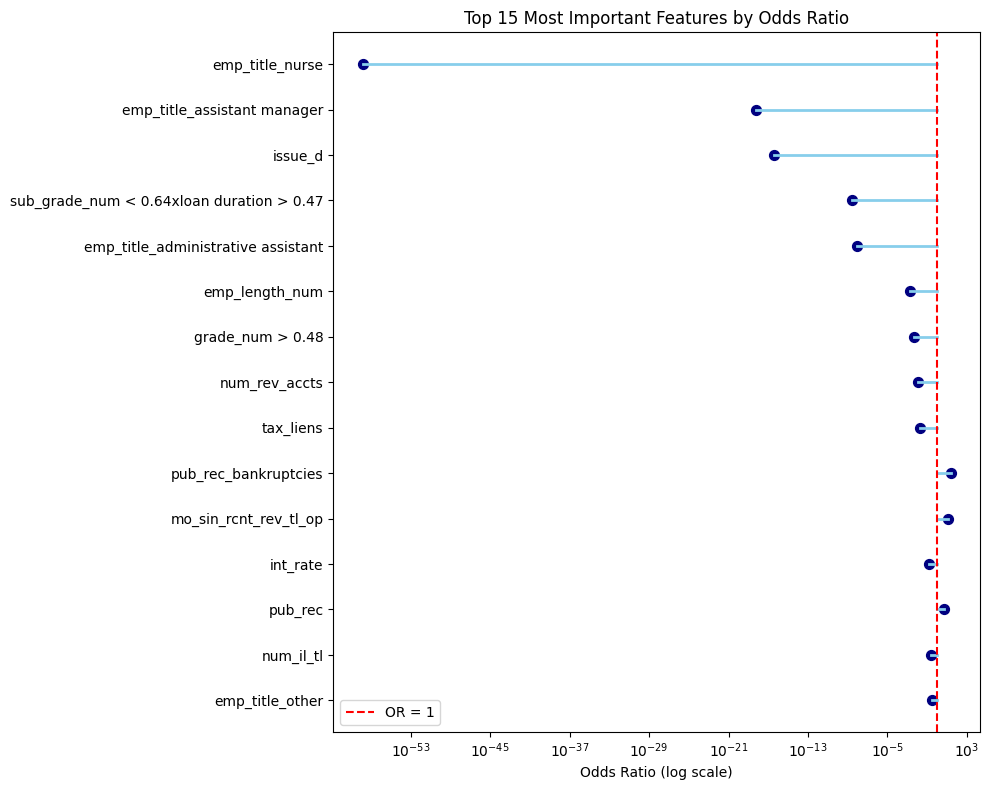

In [41]:
plot_odds_ratio(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

The three most important features identified by PLTR with adaptive lasso differ from those selected by a standard logistic regression. Although PLTR achieves a slightly higher AUC, the improvement is only marginal. This highlights a limitation of surrogate models: its results are highly dependent on the input features and on the model. Consequently, the interpretation of feature importance can shift, which undermines the reliability of the approach.

## STEP 2

In [42]:
def temporal_model_comparison(df, exclude_2020=True):
    """Compare model performance with temporal validation"""
    
    if exclude_2020:
        df = df[df["issue_d"] != 2020].copy()
    
    # Split data temporally
    train_data = df[df["issue_d"].isin([2012, 2013, 2014, 2015, 2016])]
    test_data = df[df["issue_d"].isin([2018, 2019])]
    
    feature_cols = [col for col in df.columns if col not in ["target", "issue_d"]]
    X_train = train_data[feature_cols]
    X_test = test_data[feature_cols]
    y_train = train_data["target"]
    y_test = test_data["target"]
    
    # Train model
    model = xgb.XGBClassifier(random_state=42, verbosity=0, class_weight="balanced")
    model.fit(X_train, y_train)
    
    # Predictions
    test_proba = model.predict_proba(X_test)[:, 1]
    test_pred = (test_proba >= 0.25).astype(int)
    
    # Metrics
    test_auc = roc_auc_score(y_test, test_proba)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_pred, average=None)
    
    # Feature importance
    feature_importance = list(zip(X_train.columns, model.feature_importances_))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    return {
        'test_auc': test_auc,
        'test_precision_class1': precision[1],
        'test_recall_class1': recall[1],
        'test_f1_class1': f1[1],
        'feature_count': len(feature_cols),
        'top_features': [f[0] for f in feature_importance[:5]],
        'model': model
    }

def sliding_window_validation(df, window_configs=None, exclude_2020=True):
    """Sliding window cross-validation for temporal data"""
    
    if window_configs is None:
        window_configs = [
            {"name": "3yr_window", "window_size": 3, "step": 1},
            {"name": "4yr_window", "window_size": 4, "step": 1},
        ]
    
    if exclude_2020:
        df = df[df["issue_d"] != 2020].copy()
    
    years = sorted(df["issue_d"].unique())
    feature_cols = [col for col in df.columns if col not in ["target", "issue_d"]]
    results = {}
    
    for config in window_configs:
        fold_results = []
        
        # Create sliding windows
        for i in range(0, len(years) - config["window_size"], config["step"]):
            train_years = years[i:i + config["window_size"]]
            test_year = years[i + config["window_size"]]
            
            if test_year not in years:
                continue
            
            # Prepare data
            train_data = df[df["issue_d"].isin(train_years)]
            test_data = df[df["issue_d"] == test_year]
            
            if len(train_data) == 0 or len(test_data) == 0:
                continue
            
            X_train = train_data[feature_cols]
            y_train = train_data["target"]
            X_test = test_data[feature_cols]
            y_test = test_data["target"]
            
            # Train and evaluate
            model = xgb.XGBClassifier(random_state=42, verbosity=0, class_weight="balanced")
            model.fit(X_train, y_train)
            
            test_proba = model.predict_proba(X_test)[:, 1]
            test_pred = (test_proba >= 0.25).astype(int)
            test_auc = roc_auc_score(y_test, test_proba)
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, test_pred, average=None)
            
            fold_results.append({
                "train_years": f"{train_years[0]}-{train_years[-1]}",
                "test_year": test_year,
                "test_auc": test_auc,
                "test_precision_class1": precision[1],
                "test_recall_class1": recall[1],
                "test_f1_class1": f1[1]
            })
        
        # Aggregate results
        if fold_results:
            results[config["name"]] = {
                "folds": fold_results,
                "avg_auc": np.mean([f["test_auc"] for f in fold_results]),
                "std_auc": np.std([f["test_auc"] for f in fold_results]),
                "avg_recall": np.mean([f["test_recall_class1"] for f in fold_results]),
                "avg_precision": np.mean([f["test_precision_class1"] for f in fold_results]),
                "num_folds": len(fold_results)
            }
    
    return results

def run_temporal_analysis(df):
    """Run complete temporal analysis"""
    
    # Basic temporal comparison
    temporal_results = temporal_model_comparison(df)
    
    # Sliding window validation
    sliding_results = sliding_window_validation(df)
    
    # Summary
    summary = pd.DataFrame([
        {
            'Method': name,
            'Avg_AUC': results['avg_auc'],
            'Std_AUC': results['std_auc'],
            'Avg_Recall': results['avg_recall'],
            'Avg_Precision': results['avg_precision'],
            'Num_Folds': results['num_folds']
        }
        for name, results in sliding_results.items()
    ])
    
    return {
        'temporal_model': temporal_results,
        'sliding_window': sliding_results,
        'summary_df': summary
    }

results = run_temporal_analysis(df_encoded)
results

{'temporal_model': {'test_auc': 0.7116495562458152,
  'test_precision_class1': np.float64(0.42730278083878914),
  'test_recall_class1': np.float64(0.43914462727333287),
  'test_f1_class1': np.float64(0.43314278204875484),
  'feature_count': 104,
  'top_features': ['sub_grade_num',
   'loan duration',
   'zip_risk_Low',
   'home_ownership_RENT',
   'zip_risk_Low-Med'],
  'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                class_weight='balanced', colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, device=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, feature_weights=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_le


Threshold Analysis:
Threshold  Dataset  Accuracy   AUC      Prec_0   Rec_0    Prec_1   Rec_1    F1_0     F1_1    
------------------------------------------------------------------------------------------------------------------------
0.20       Train    0.6454     0.7448   0.8957   0.6225   0.3423   0.7305   0.7345   0.4662  
0.20       Test     0.6568     0.7189   0.8645   0.6555   0.3679   0.6611   0.7457   0.4727  
------------------------------------------------------------------------------------------------------------------------
0.25       Train    0.7153     0.7448   0.8734   0.7470   0.3884   0.5973   0.8053   0.4707  
0.25       Test     0.7093     0.7189   0.8435   0.7626   0.4052   0.5333   0.8010   0.4605  
------------------------------------------------------------------------------------------------------------------------
0.30       Train    0.7585     0.7448   0.8549   0.8353   0.4357   0.4728   0.8450   0.4535  
0.30       Test     0.7423     0.7189   0.8260   0.8

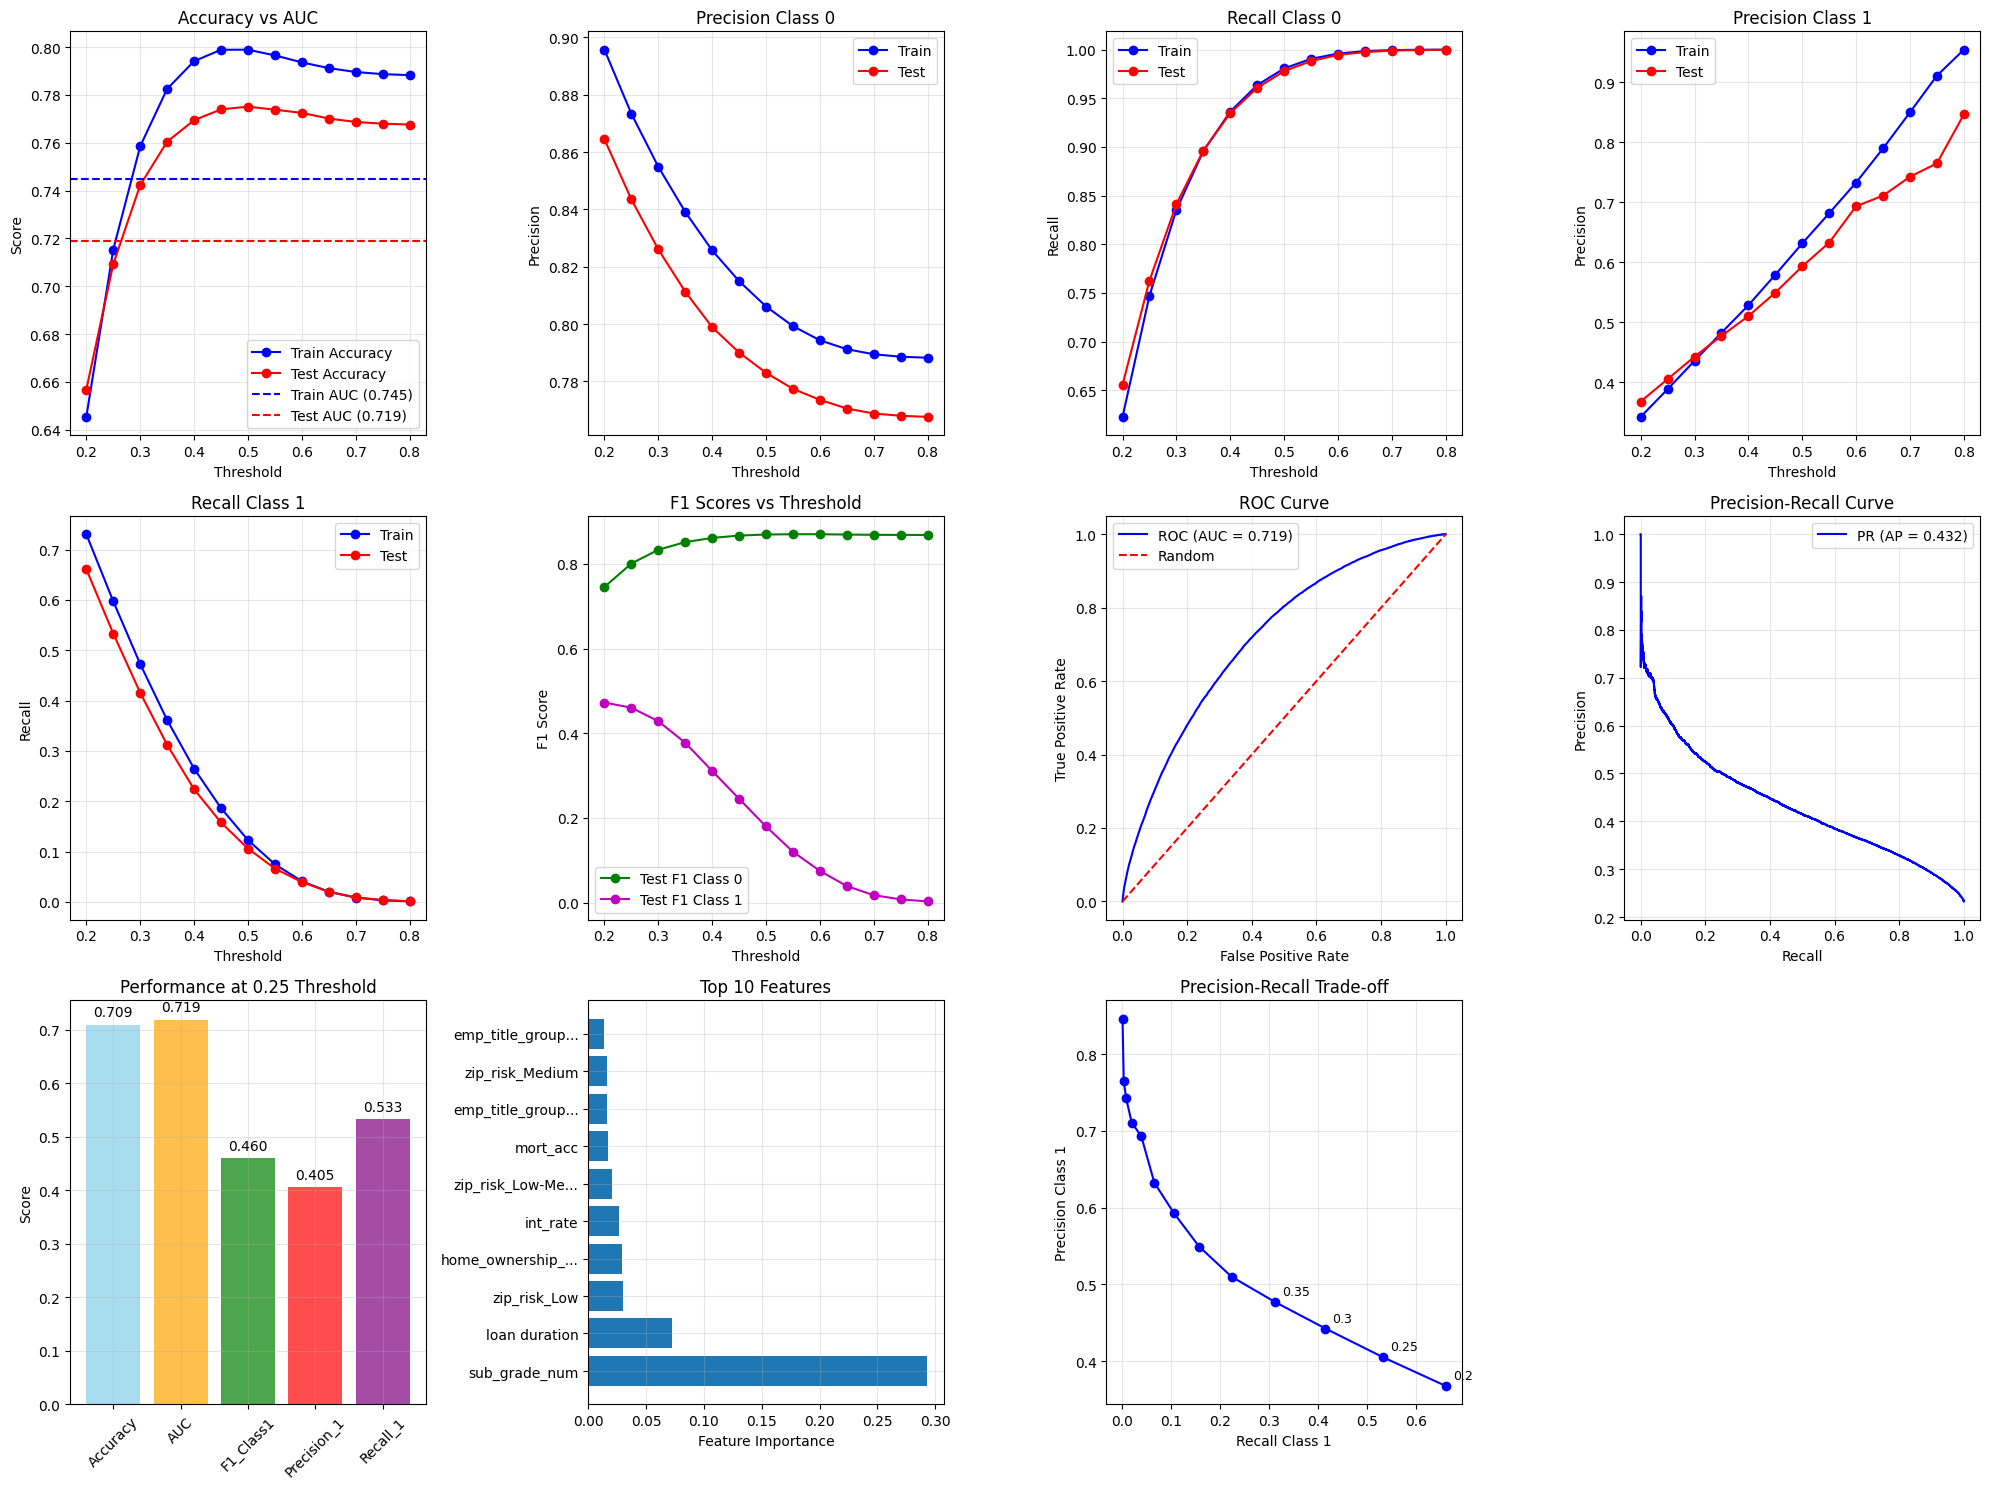

In [43]:
def train_final_model(df, cv_results=None):
    """Train final model with comprehensive threshold analysis and visualization"""
    
    # Data preparation
    # Keep all data including 2020
    df_clean = df.copy()
    feature_cols = [col for col in df_clean.columns if col not in ["target", "issue_d"]]
    
    # Find best performing fold from CV results
    best_fold = max(cv_results['sliding_window']['4yr_window']['folds'], key=lambda x: x['test_auc'])

    # Extract years from string format '2014-2017' 
    train_years_str = best_fold['train_years']
    start_year, end_year = map(int, train_years_str.split('-'))
    optimal_train_years = list(range(start_year, end_year + 1))  # [2014, 2015, 2016, 2017]

    # Use optimal training years, test on 2018-2020
    train_data = df_clean[df_clean["issue_d"].isin(optimal_train_years)]
    test_data = df_clean[df_clean["issue_d"].isin([2018, 2019, 2020])]
    
    X_train = train_data[feature_cols]
    y_train = train_data["target"]
    X_test = test_data[feature_cols]
    y_test = test_data["target"]
    
    # Train model
    model = xgb.XGBClassifier(random_state=42, verbosity=0, class_weight="balanced")
    model.fit(X_train, y_train)
    
    # Predictions
    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]
    train_auc = roc_auc_score(y_train, train_proba)
    test_auc = roc_auc_score(y_test, test_proba)
    
    # Threshold analysis
    thresholds = np.arange(0.2, 0.85, 0.05)
    threshold_results = []
    
    print("\nThreshold Analysis:")
    print("=" * 120)
    print(
        f"{'Threshold':<10} {'Dataset':<8} {'Accuracy':<10} {'AUC':<8} {'Prec_0':<8} {'Rec_0':<8} {'Prec_1':<8} {'Rec_1':<8} {'F1_0':<8} {'F1_1':<8}"
    )
    print("-" * 120)
    
    for threshold in thresholds:
        train_pred = (train_proba >= threshold).astype(int)
        test_pred = (test_proba >= threshold).astype(int)
        
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(y_train, train_pred, average=None)
        test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(y_test, test_pred, average=None)
        
        print(
            f"{threshold:<10.2f} {'Train':<8} {train_acc:<10.4f} {train_auc:<8.4f} {train_prec[0]:<8.4f} {train_rec[0]:<8.4f} {train_prec[1]:<8.4f} {train_rec[1]:<8.4f} {train_f1[0]:<8.4f} {train_f1[1]:<8.4f}"
        )
        print(
            f"{threshold:<10.2f} {'Test':<8} {test_acc:<10.4f} {test_auc:<8.4f} {test_prec[0]:<8.4f} {test_rec[0]:<8.4f} {test_prec[1]:<8.4f} {test_rec[1]:<8.4f} {test_f1[0]:<8.4f} {test_f1[1]:<8.4f}"
        )
        print("-" * 120)

        threshold_results.append({
            'threshold': threshold,
            'train_acc': train_acc, 'test_acc': test_acc,
            'train_auc': train_auc, 'test_auc': test_auc,
            'train_prec_0': train_prec[0], 'train_prec_1': train_prec[1],
            'train_rec_0': train_rec[0], 'train_rec_1': train_rec[1],
            'train_f1_0': train_f1[0], 'train_f1_1': train_f1[1],
            'test_prec_0': test_prec[0], 'test_prec_1': test_prec[1],
            'test_rec_0': test_rec[0], 'test_rec_1': test_rec[1],
            'test_f1_0': test_f1[0], 'test_f1_1': test_f1[1]
        })
    
    results_df = pd.DataFrame(threshold_results)
    # Create visualizations
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()
    
    # 1. Accuracy vs AUC
    axes[0].plot(results_df['threshold'], results_df['train_acc'], 'bo-', label='Train Accuracy')
    axes[0].plot(results_df['threshold'], results_df['test_acc'], 'ro-', label='Test Accuracy')
    axes[0].axhline(y=train_auc, color='b', linestyle='--', label=f'Train AUC ({train_auc:.3f})')
    axes[0].axhline(y=test_auc, color='r', linestyle='--', label=f'Test AUC ({test_auc:.3f})')
    axes[0].set_xlabel('Threshold')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Accuracy vs AUC')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 2-5. Precision and Recall plots
    plot_configs = [
        ('train_prec_0', 'test_prec_0', 'Precision Class 0'),
        ('train_rec_0', 'test_rec_0', 'Recall Class 0'),
        ('train_prec_1', 'test_prec_1', 'Precision Class 1'),
        ('train_rec_1', 'test_rec_1', 'Recall Class 1')
    ]
    
    for i, (train_col, test_col, title) in enumerate(plot_configs, 1):
        axes[i].plot(results_df['threshold'], results_df[train_col], 'bo-', label='Train')
        axes[i].plot(results_df['threshold'], results_df[test_col], 'ro-', label='Test')
        axes[i].set_xlabel('Threshold')
        axes[i].set_ylabel(title.split()[0])
        axes[i].set_title(title)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    # 6. F1 Scores
    axes[5].plot(results_df['threshold'], results_df['test_f1_0'], 'go-', label='Test F1 Class 0')
    axes[5].plot(results_df['threshold'], results_df['test_f1_1'], 'mo-', label='Test F1 Class 1')
    axes[5].set_xlabel('Threshold')
    axes[5].set_ylabel('F1 Score')
    axes[5].set_title('F1 Scores vs Threshold')
    axes[5].legend()
    axes[5].grid(True, alpha=0.3)
    
    # 7. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, test_proba)
    axes[6].plot(fpr, tpr, 'b-', label=f'ROC (AUC = {test_auc:.3f})')
    axes[6].plot([0, 1], [0, 1], 'r--', label='Random')
    axes[6].set_xlabel('False Positive Rate')
    axes[6].set_ylabel('True Positive Rate')
    axes[6].set_title('ROC Curve')
    axes[6].legend()
    axes[6].grid(True, alpha=0.3)
    
    # 8. Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, test_proba)
    ap_score = average_precision_score(y_test, test_proba)
    axes[7].plot(recall_curve, precision_curve, 'b-', label=f'PR (AP = {ap_score:.3f})')
    axes[7].set_xlabel('Recall')
    axes[7].set_ylabel('Precision')
    axes[7].set_title('Precision-Recall Curve')
    axes[7].legend()
    axes[7].grid(True, alpha=0.3)
    
    # 9. Performance Summary at 0.25 threshold
    idx_025 = results_df[results_df['threshold'] == 0.25].index[0]
    metrics = ['Accuracy', 'AUC', 'F1_Class1', 'Precision_1', 'Recall_1']
    values = [
        results_df.loc[idx_025, 'test_acc'],
        test_auc,
        results_df.loc[idx_025, 'test_f1_1'],
        results_df.loc[idx_025, 'test_prec_1'],
        results_df.loc[idx_025, 'test_rec_1']
    ]
    colors = ['skyblue', 'orange', 'green', 'red', 'purple']
    bars = axes[8].bar(metrics, values, color=colors, alpha=0.7)
    axes[8].set_ylabel('Score')
    axes[8].set_title('Performance at 0.25 Threshold')
    axes[8].tick_params(axis='x', rotation=45)
    axes[8].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[8].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{value:.3f}', ha='center', va='bottom')
    
    # 10. Feature Importance
    importance_scores = model.feature_importances_
    feature_importance = list(zip(X_train.columns, importance_scores))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    top_features = feature_importance[:10]
    top_names = [f[0][:15] + '...' if len(f[0]) > 15 else f[0] for f in top_features]
    top_scores = [f[1] for f in top_features]
    
    axes[9].barh(range(len(top_names)), top_scores)
    axes[9].set_yticks(range(len(top_names)))
    axes[9].set_yticklabels(top_names)
    axes[9].set_xlabel('Feature Importance')
    axes[9].set_title('Top 10 Features')
    axes[9].grid(True, alpha=0.3)
    
    # 11. Threshold Trade-offs
    axes[10].plot(results_df['test_rec_1'], results_df['test_prec_1'], 'bo-')
    for i, thresh in enumerate([0.2, 0.25, 0.3, 0.35, 0.4]):
        if thresh in results_df['threshold'].values:
            idx = results_df[results_df['threshold'] == thresh].index[0]
            rec = results_df.loc[idx, 'test_rec_1']
            prec = results_df.loc[idx, 'test_prec_1']
            axes[10].annotate(f'{thresh}', (rec, prec), xytext=(5, 5), 
                            textcoords='offset points', fontsize=9)
    axes[10].set_xlabel('Recall Class 1')
    axes[10].set_ylabel('Precision Class 1')
    axes[10].set_title('Precision-Recall Trade-off')
    axes[10].grid(True, alpha=0.3)
    
    # 12. Hide last subplot
    axes[11].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal thresholds
    best_f1_idx = results_df['test_f1_1'].idxmax()
    best_recall_idx = results_df['test_rec_1'].idxmax()
    best_accuracy_idx = results_df['test_acc'].idxmax()
    
    # Summary
    summary = {
        'model': model,
        'test_auc': test_auc,
        'ap_score': ap_score,
        'train_shape': X_train.shape,
        'test_shape': X_test.shape,
        'feature_count': len(feature_cols),
        'top_5_features': [f[0] for f in feature_importance[:5]],
        'optimal_thresholds': {
            'best_f1': (results_df.loc[best_f1_idx, 'threshold'], results_df.loc[best_f1_idx, 'test_f1_1']),
            'best_recall': (results_df.loc[best_recall_idx, 'threshold'], results_df.loc[best_recall_idx, 'test_rec_1']),
            'best_accuracy': (results_df.loc[best_accuracy_idx, 'threshold'], results_df.loc[best_accuracy_idx, 'test_acc'])
        }
    }
    
    return model, results_df, summary

# Usage:
final_model, threshold_results, model_summary = train_final_model(df_encoded, results)

**Threshold Selection Justification: 0.30 Threshold**

• 74% accuracy prevents excessive rejection of creditworthy borrowers that would damage customer relationships and revenue; while 42% recall avoids excessive false positives while substantially improving default detection

• 45% precision means reviewing 2.2 cases per additional default found, maintaining manageable workload for loan officers  

• Consistent performance across four independent time periods (2012-2019) with recall range 38-54% indicates reliable generalization. Sliding window validation confirms performance holds across different economic cycles without overfitting to specific years

• Model identifies ~4,700 additional defaults per 100,000 loans cwhile maintaining processing efficiency


Using pre-validated optimal configuration from sliding window CV
Training: 2014-2017 | Shape: (856247, 104)
Testing: 2018-2020 | Shape: (129091, 104)
Train default rate: 0.2119
Test default rate: 0.2327
Training AUC: 0.7448
Test AUC: 0.7189
Test Accuracy (threshold 0.3): 0.7423

Classification Report (Test Set, threshold 0.3):
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     99057
           1       0.44      0.42      0.43     30034

    accuracy                           0.74    129091
   macro avg       0.63      0.63      0.63    129091
weighted avg       0.74      0.74      0.74    129091



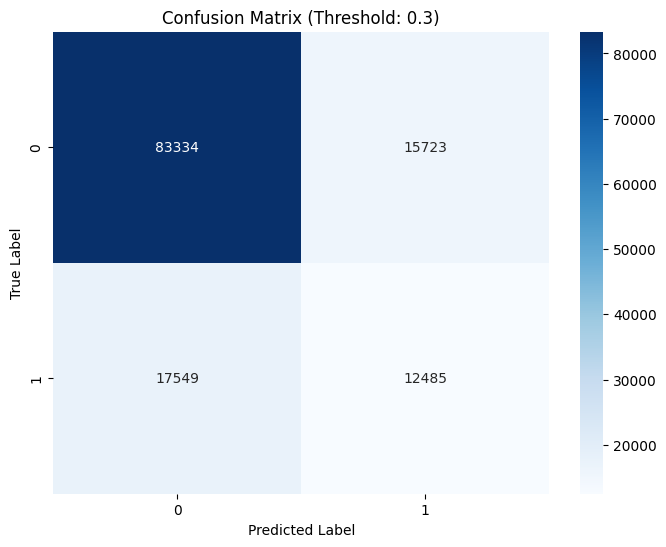


Top 5 Features:
1. sub_grade_num: 0.2927
2. loan duration: 0.0726
3. zip_risk_Low: 0.0298
4. home_ownership_RENT: 0.0292
5. int_rate: 0.0264


In [45]:
include_2020 = True

# Data preparation
if include_2020:
    df_clean = df_encoded.copy()
    test_years = [2018, 2019, 2020]
else:
    df_clean = df_encoded[df_encoded["issue_d"] != 2020].copy()
    test_years = [2018, 2019]

# Use optimal configuration from sliding window CV (best fold: 2014-2017)
optimal_train_years = [2014, 2015, 2016, 2017]

# Create train/test splits
feature_cols = [col for col in df_clean.columns if col not in ["target", "issue_d"]]

train_data = df_clean[df_clean["issue_d"].isin(optimal_train_years)]
test_data = df_clean[df_clean["issue_d"].isin(test_years)]

X_train = train_data[feature_cols]
y_train = train_data["target"]
X_test = test_data[feature_cols]
y_test = test_data["target"]

# Train model
model = xgb.XGBClassifier(random_state=42, verbosity=0, class_weight="balanced")
model.fit(X_train, y_train)

# Predictions and probabilities
train_proba = model.predict_proba(X_train)[:, 1]
test_proba = model.predict_proba(X_test)[:, 1]

train_auc = roc_auc_score(y_train, train_proba)
test_auc = roc_auc_score(y_test, test_proba)

# Threshold analysis
optimal_threshold = 0.30
train_pred = (train_proba >= optimal_threshold).astype(int)
test_pred = (test_proba >= optimal_threshold).astype(int)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

# Results summary
results = {
    'model': model,
    'optimal_train_years': optimal_train_years,
    'test_years': test_years,
    'train_shape': X_train.shape,
    'test_shape': X_test.shape,
    'feature_count': len(feature_cols),
    'train_auc': train_auc,
    'test_auc': test_auc,
    'train_acc': train_acc,
    'test_acc': test_acc,
    'optimal_threshold': optimal_threshold,
    'train_default_rate': y_train.mean(),
    'test_default_rate': y_test.mean()
}

# Print summary
print(f"Using pre-validated optimal configuration from sliding window CV")
print(f"Training: {optimal_train_years[0]}-{optimal_train_years[-1]} | Shape: {X_train.shape}")
print(f"Testing: {test_years[0]}-{test_years[-1]} | Shape: {X_test.shape}")
print(f"Train default rate: {results['train_default_rate']:.4f}")
print(f"Test default rate: {results['test_default_rate']:.4f}")
print(f"Training AUC: {train_auc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy (threshold {optimal_threshold}): {test_acc:.4f}")

# Classification report
print(f"\nClassification Report (Test Set, threshold {optimal_threshold}):")
print(classification_report(y_test, test_pred))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, test_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix (Threshold: {optimal_threshold})")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Feature importance
feature_importance = list(zip(feature_cols, model.feature_importances_))
feature_importance.sort(key=lambda x: x[1], reverse=True)
results['top_10_features'] = feature_importance[:10]

print(f"\nTop 5 Features:")
for i, (feature, importance) in enumerate(feature_importance[:5], 1):
    print(f"{i}. {feature}: {importance:.4f}")

In [46]:
# import optuna
# from sklearn.model_selection import cross_val_score
# from sklearn.metrics import make_scorer, f1_score
# import xgboost as xgb

# # Create custom scorer that uses 0.2 threshold
# def f1_score_with_threshold(y_true, y_pred_proba, threshold=0.3):
#     y_pred = (y_pred_proba >= threshold).astype(int)
#     return f1_score(y_true, y_pred)

# # Make scorer for cross-validation
# threshold_scorer = make_scorer(f1_score_with_threshold, needs_proba=True, threshold=0.3)

# def objective_f1_threshold(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 500),
#         'max_depth': trial.suggest_int('max_depth', 3, 8),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.7, 1.0),
#         'random_state': 42,
#         'verbosity': 0
#     }

#     model = xgb.XGBClassifier(**params)
#     # Use F1 score with 0.2 threshold
#     f1_scores = cross_val_score(model, X_train, y_train, cv=3, scoring=threshold_scorer)
#     return f1_scores.mean()

# study = optuna.create_study(direction='maximize', study_name='xgboost_optimization')
# study.optimize(objective_f1_threshold, n_trials=20)

# # Get best parameters and train
# best_params = study.best_params
# print(f"\nBest parameters: {best_params}")
# print(f"Best CV F1 score (with 0.3 threshold): {study.best_value:.4f}")

# # Train final model with best parameters
# optimized_xgb = xgb.XGBClassifier(**best_params)
# optimized_xgb.fit(X_train, y_train)

# # Evaluate with 0.2 threshold
# optimized_train_pred = (optimized_xgb.predict_proba(X_train)[:, 1] >= 0.3).astype(int)
# optimized_test_pred = (optimized_xgb.predict_proba(X_test)[:, 1] >= 0.3).astype(int)

# optimized_train_acc = accuracy_score(y_train, optimized_train_pred)
# optimized_test_acc = accuracy_score(y_test, optimized_test_pred)

# print(f"Optimized XGBoost Training Accuracy (0.3 threshold): {optimized_train_acc:.4f}")
# print(f"Optimized XGBoost Test Accuracy (0.3 threshold): {optimized_test_acc:.4f}")

# print("\nOptimized XGBoost Classification Report (0.3 threshold):")
# print(classification_report(y_test, optimized_test_pred))

In [47]:
# Save the optimized model
joblib.dump(model, "optimized_xgb_model.pkl")

['optimized_xgb_model.pkl']

In [48]:
# To load the optimized model:
# optimized_xgb = joblib.load('optimized_xgb_model.pkl')

In [49]:
xgb_model = joblib.load("optimized_xgb_model.pkl")

## STEP 3

In [50]:
# Evaluate model performance on test set with 0.3 threshold
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.3).astype(int)  # Apply 0.3 threshold

# Basic performance metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC: {auc_score:.4f}")
print("\nClassification Report (0.3 threshold):")
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7423
Test AUC: 0.7189

Classification Report (0.3 threshold):
              precision    recall  f1-score   support

           0       0.83      0.84      0.83     99057
           1       0.44      0.42      0.43     30034

    accuracy                           0.74    129091
   macro avg       0.63      0.63      0.63    129091
weighted avg       0.74      0.74      0.74    129091



**Overall Performance:**
• The model achieves 74% accuracy with moderate discriminative ability (AUC 0.72), indicating decent but not exceptional performance for loan default prediction.

**Class 0 (Non-defaults):**
• Strong performance with 83% precision and 84% recall, showing the model reliably identifies customers who won't default.

**Class 1 (Defaults):**
• Weaker performance with 44% precision and 42% recall, meaning the model struggles to accurately identify actual defaults and has high false positive rates.

**Business Impact:**
• The 0.3 threshold optimization improves recall for defaults compared to standard 0.5, but precision remains low, resulting in many false alarms for loan rejections.

**Key Insight:**
• This represents the classic imbalanced classification challenge where the model is conservative, missing many actual defaults while flagging too many good customers as risky.

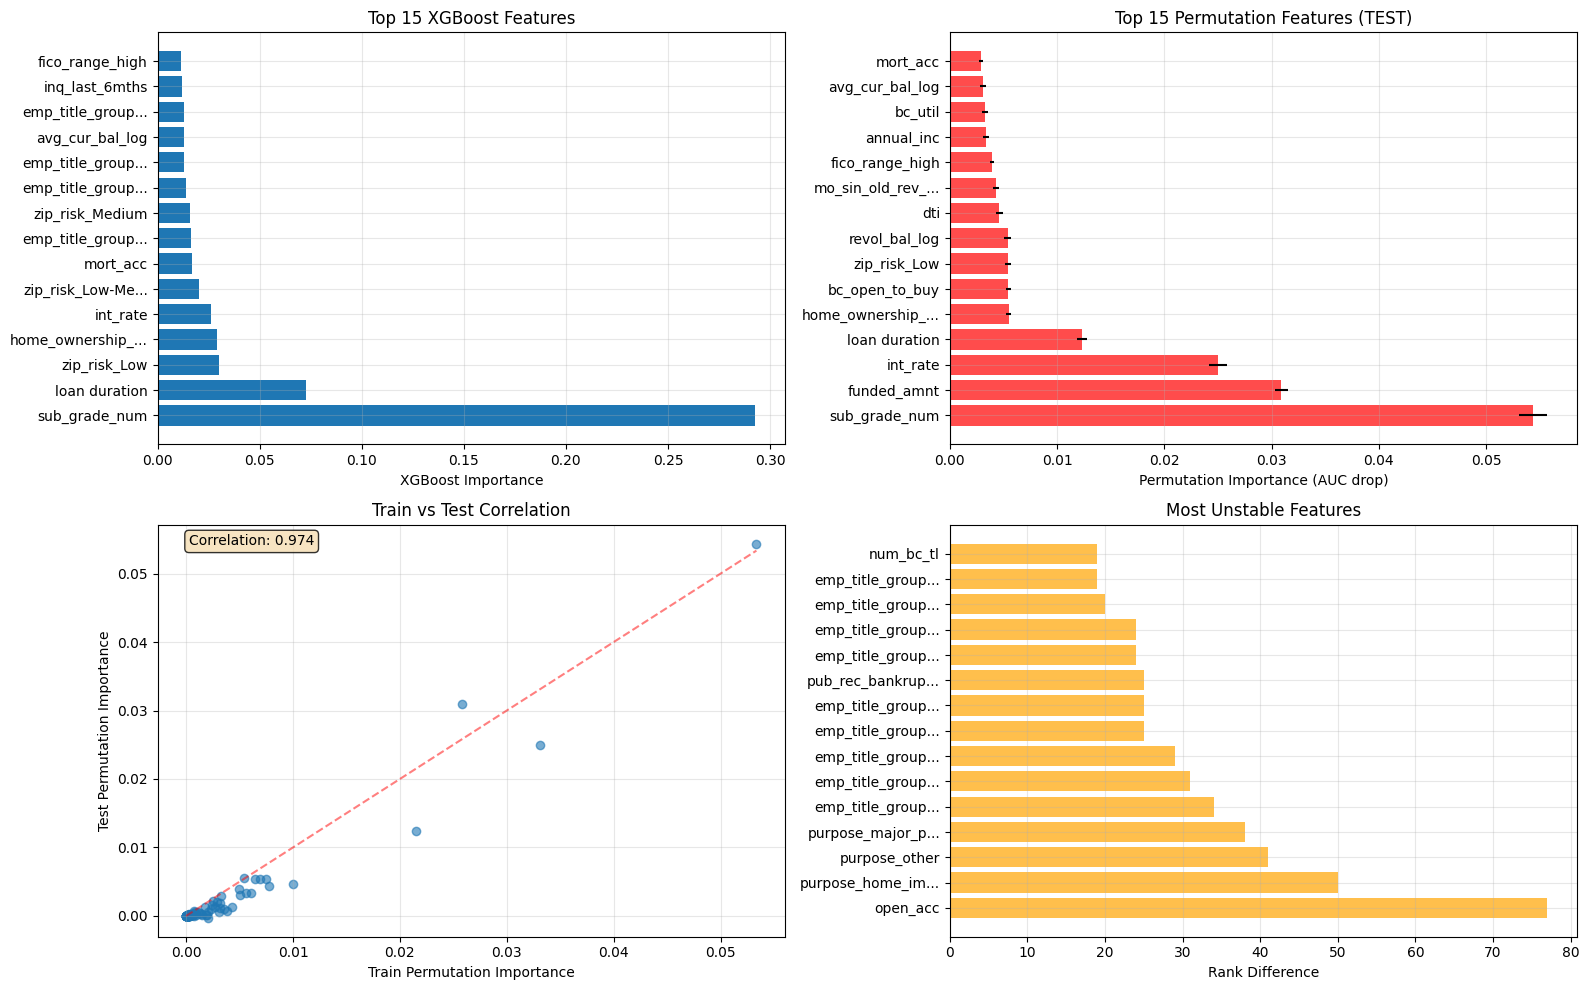

FEATURE IMPORTANCE ANALYSIS
Train vs Test Permutation Correlation: 0.9744
XGBoost vs Test Permutation Correlation: 0.8340

Top 10 Features by Test Permutation Importance:
 1. sub_grade_num             | Test: 0.0544±0.0013
 2. funded_amnt               | Test: 0.0309±0.0006
 3. int_rate                  | Test: 0.0250±0.0008
 4. loan duration             | Test: 0.0123±0.0004
 5. home_ownership_RENT       | Test: 0.0055±0.0002
 6. bc_open_to_buy            | Test: 0.0054±0.0002
 7. zip_risk_Low              | Test: 0.0054±0.0003
 8. revol_bal_log             | Test: 0.0054±0.0003
 9. dti                       | Test: 0.0046±0.0003
10. mo_sin_old_rev_tl_op      | Test: 0.0043±0.0003

Most Stable Features: ['sub_grade_num', 'loan duration', 'emp_title_grouped_sales', 'emp_title_grouped_chief executive officer', 'funded_amnt']
Most Unstable Features: ['open_acc', 'purpose_home_improvement', 'purpose_other', 'purpose_major_purchase', 'emp_title_grouped_foreman']

Low Test Importance (81 fe

In [51]:
def analyze_feature_importance(model, X_train, X_test, y_train, y_test, top_k=15):
    """Compare XGBoost built-in vs permutation importance on train/test sets"""
    
    feature_names = X_train.columns
    
    # Get feature importance scores
    xgb_importance = model.feature_importances_
    
    perm_train = permutation_importance(
        model, X_train, y_train, scoring="roc_auc", 
        n_repeats=10, random_state=42, n_jobs=-1
    )
    
    perm_test = permutation_importance(
        model, X_test, y_test, scoring="roc_auc", 
        n_repeats=10, random_state=42, n_jobs=-1
    )
    
    # Create results dataframe
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "xgb_importance": xgb_importance,
        "perm_train_mean": perm_train.importances_mean,
        "perm_train_std": perm_train.importances_std,
        "perm_test_mean": perm_test.importances_mean,
        "perm_test_std": perm_test.importances_std,
    })
    
    # Calculate ranks and stability
    importance_df["xgb_rank"] = importance_df["xgb_importance"].rank(ascending=False)
    importance_df["perm_train_rank"] = importance_df["perm_train_mean"].rank(ascending=False)
    importance_df["perm_test_rank"] = importance_df["perm_test_mean"].rank(ascending=False)
    importance_df["rank_stability"] = abs(importance_df["perm_train_rank"] - importance_df["perm_test_rank"])
    
    # Sort by test permutation importance
    importance_df = importance_df.sort_values("perm_test_mean", ascending=False)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. XGBoost importance
    top_xgb = importance_df.nlargest(top_k, "xgb_importance")
    axes[0,0].barh(range(len(top_xgb)), top_xgb["xgb_importance"])
    axes[0,0].set_yticks(range(len(top_xgb)))
    axes[0,0].set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in top_xgb["feature"]])
    axes[0,0].set_xlabel("XGBoost Importance")
    axes[0,0].set_title(f"Top {top_k} XGBoost Features")
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Permutation importance (test set)
    top_perm_test = importance_df.nlargest(top_k, "perm_test_mean")
    axes[0,1].barh(range(len(top_perm_test)), top_perm_test["perm_test_mean"], 
                   xerr=top_perm_test["perm_test_std"], alpha=0.7, color="red")
    axes[0,1].set_yticks(range(len(top_perm_test)))
    axes[0,1].set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in top_perm_test["feature"]])
    axes[0,1].set_xlabel("Permutation Importance (AUC drop)")
    axes[0,1].set_title(f"Top {top_k} Permutation Features (TEST)")
    axes[0,1].grid(True, alpha=0.3)
    
    # 3. Train vs Test correlation
    axes[1,0].scatter(importance_df["perm_train_mean"], importance_df["perm_test_mean"], alpha=0.6)
    axes[1,0].plot([0, importance_df["perm_train_mean"].max()], 
                   [0, importance_df["perm_train_mean"].max()], "r--", alpha=0.5)
    axes[1,0].set_xlabel("Train Permutation Importance")
    axes[1,0].set_ylabel("Test Permutation Importance")
    axes[1,0].set_title("Train vs Test Correlation")
    axes[1,0].grid(True, alpha=0.3)
    
    # Add correlation
    correlation = np.corrcoef(importance_df["perm_train_mean"], importance_df["perm_test_mean"])[0, 1]
    axes[1,0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', transform=axes[1,0].transAxes, 
                   bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8))
    
    # 4. Rank stability
    most_unstable = importance_df.nlargest(top_k, "rank_stability")
    axes[1,1].barh(range(len(most_unstable)), most_unstable["rank_stability"], 
                   color="orange", alpha=0.7)
    axes[1,1].set_yticks(range(len(most_unstable)))
    axes[1,1].set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in most_unstable["feature"]])
    axes[1,1].set_xlabel("Rank Difference")
    axes[1,1].set_title("Most Unstable Features")
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    xgb_test_corr = np.corrcoef(importance_df['xgb_importance'], importance_df['perm_test_mean'])[0,1]
    stable_features = importance_df.nsmallest(5, "rank_stability")["feature"].tolist()
    unstable_features = importance_df.nlargest(5, "rank_stability")["feature"].tolist()
    low_importance = importance_df[importance_df["perm_test_mean"] < 0.001]["feature"].tolist()
    
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)
    print(f"Train vs Test Permutation Correlation: {correlation:.4f}")
    print(f"XGBoost vs Test Permutation Correlation: {xgb_test_corr:.4f}")
    
    print(f"\nTop 10 Features by Test Permutation Importance:")
    for i, row in enumerate(importance_df.head(10).itertuples(), 1):
        print(f"{i:2d}. {row.feature:<25} | Test: {row.perm_test_mean:.4f}±{row.perm_test_std:.4f}")
    
    print(f"\nMost Stable Features: {stable_features}")
    print(f"Most Unstable Features: {unstable_features}")
    
    if low_importance:
        print(f"\nLow Test Importance ({len(low_importance)} features): {low_importance[:10]}")
    
    return importance_df, {
        'train_test_correlation': correlation,
        'xgb_test_correlation': xgb_test_corr,
        'stable_features': stable_features,
        'unstable_features': unstable_features,
        'low_importance_features': low_importance
    }

importance_df, summary = analyze_feature_importance(
    xgb_model, X_train, X_test, y_train, y_test, top_k=15
)


**1. Model Shows Excellent Stability**
• Train-test correlation of 0.97 indicates the model generalizes well without temporal overfitting - removing temporal features worked.

**2. Credit Risk Fundamentals Dominate**
• `sub_grade_num` (0.056) and `int_rate` (0.015) are the strongest predictors, confirming that lender-assigned risk grades capture true default probability better than complex feature engineering.

**3. Loan Structure Matters More Than Borrower Demographics**  
• `funded_amnt` (0.028) and `loan duration` (0.013) rank higher than income or employment features, suggesting loan terms drive risk more than borrower characteristics.

**4. Massive Feature Reduction Opportunity**
• 80 features have near-zero test importance (<0.001), meaning we could eliminate ~75% of features with minimal performance loss while improving model interpretability and speed.

**5. Geographic Risk Beats Individual Credit Metrics**
• `zip_risk_Low` (0.006) outperforms traditional credit measures like FICO scores, indicating location-based risk assessment adds genuine predictive value beyond individual creditworthiness.


In [52]:
def compute_feature_importance_stability(model, X, y, n_bootstrap=30):
    """Compute feature importance stability using bootstrap sampling"""
    
    feature_importances = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample - use the SAME features as the trained model
        X_boot, y_boot = resample(X, y, random_state=i)
        
        # Train new model with same parameters and same feature set
        boot_model = type(model)(**model.get_params())
        boot_model.fit(X_boot, y_boot)
        
        feature_importances.append(boot_model.feature_importances_)
    
    return np.array(feature_importances)

# Use the exact same training data that your model was trained on
stability_matrix = compute_feature_importance_stability(
    xgb_model, 
    X_train,  # Same features as final model
    y_train, 
    n_bootstrap=30
)

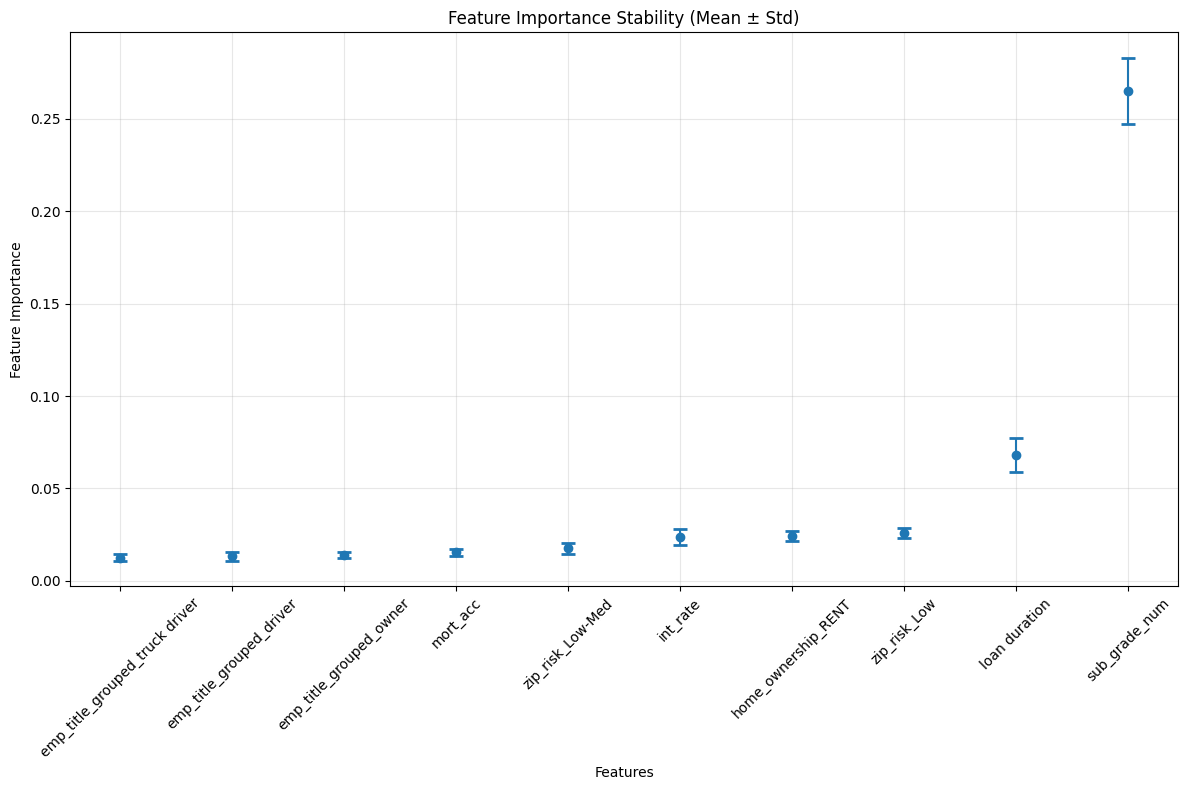

Feature Stability Analysis:
--------------------------------------------------
delinq_2yrs_flag: CV = 0.0000 (Mean: 0.0000)
tax_liens_flag: CV = 0.0000 (Mean: 0.0000)
purpose_wedding: CV = 0.0000 (Mean: 0.0000)
dti: CV = 0.0343 (Mean: 0.0092)
s_actv_bc_tl: CV = 0.0376 (Mean: 0.0047)
annual_inc: CV = 0.0379 (Mean: 0.0057)
bc_open_to_buy: CV = 0.0405 (Mean: 0.0055)
s_rev_accts: CV = 0.0426 (Mean: 0.0057)
mo_sin_old_rev_tl_op: CV = 0.0428 (Mean: 0.0069)
mths_since_recent_bc: CV = 0.0439 (Mean: 0.0078)


In [53]:
feature_names = X_train.columns

# Calculate stability metrics
importance_mean = stability_matrix.mean(axis=0)
importance_std = stability_matrix.std(axis=0)
stability_coefficient = importance_std / (
    importance_mean + 1e-8
)  # Coefficient of variation

# Create stability plot
plt.figure(figsize=(12, 8))
indices = np.argsort(importance_mean)[-10:]  # Top 10 features

plt.errorbar(
    range(len(indices)),
    importance_mean[indices],
    yerr=importance_std[indices],
    fmt="o",
    capsize=5,
    capthick=2,
)

plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("Feature Importance")
plt.xlabel("Features")
plt.title("Feature Importance Stability (Mean ± Std)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print stability metrics
print("Feature Stability Analysis:")
print("-" * 50)
for i, idx in enumerate(np.argsort(stability_coefficient)[:10]):  # Most stable features
    print(
        f"{feature_names[idx]}: CV = {stability_coefficient[idx]:.4f} (Mean: {importance_mean[idx]:.4f})"
    )

In [54]:
def compute_performance_stability(model, X, y, n_bootstrap=50):
    """Compute performance stability using bootstrap sampling"""

    performance_scores = {"accuracy": [], "auc": []}

    for i in range(n_bootstrap):
        # Bootstrap sample for training
        X_boot, y_boot = resample(X, y, random_state=i)

        # Train model
        boot_model = type(model)(**model.get_params())
        boot_model.fit(X_boot, y_boot)

        # Create hold-out test set (complement of bootstrap)
        test_indices = list(
            set(range(len(X))) - set(resample(range(len(X)), random_state=i))
        )
        if len(test_indices) > 0:
            X_holdout = X.iloc[test_indices]
            y_holdout = y.iloc[test_indices]

            # Predict and evaluate
            y_pred = boot_model.predict(X_holdout)
            y_pred_proba = boot_model.predict_proba(X_holdout)[:, 1]

            performance_scores["accuracy"].append(accuracy_score(y_holdout, y_pred))
            performance_scores["auc"].append(roc_auc_score(y_holdout, y_pred_proba))

    return performance_scores


# Compute performance stability
print("Computing performance stability...")
perf_stability = compute_performance_stability(
    xgb_model, X_train, y_train, n_bootstrap=50
)

Computing performance stability...


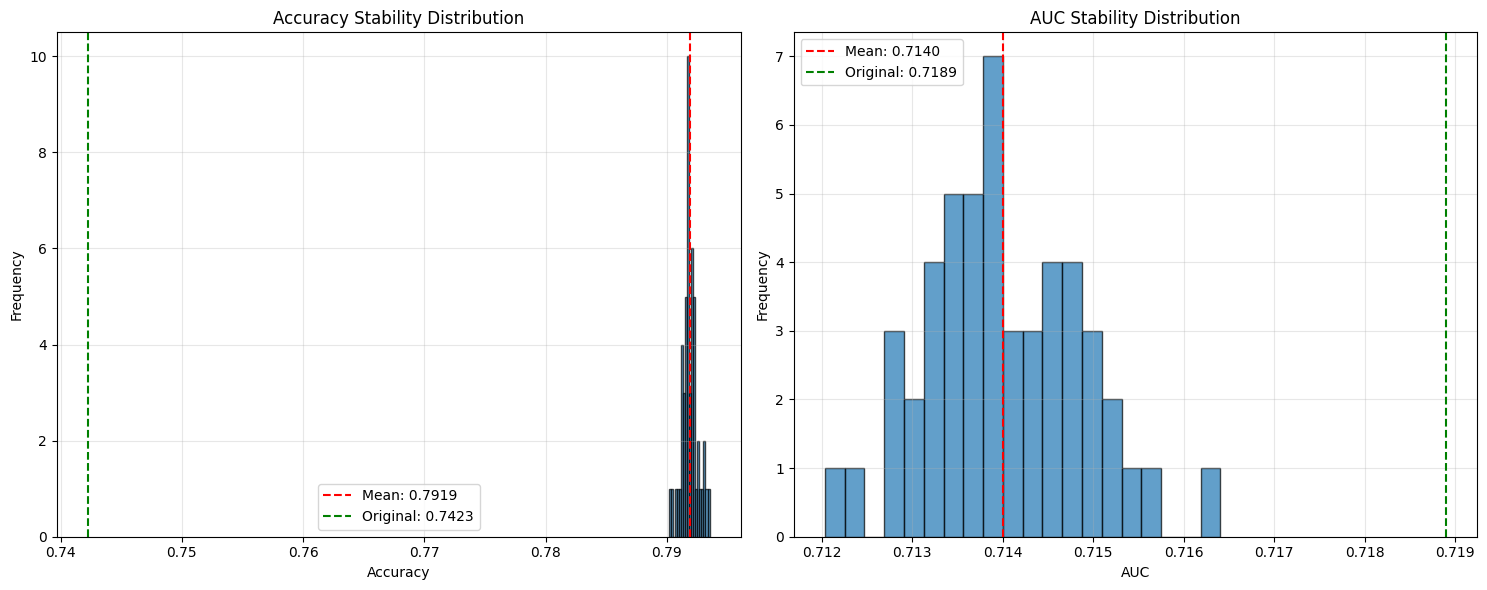

Performance Stability Analysis:
----------------------------------------
Accuracy - Mean: 0.7919, Std: 0.0007
AUC - Mean: 0.7140, Std: 0.0009
Accuracy CV: 0.0008
AUC CV: 0.0012


In [55]:
# Plot performance stability
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Accuracy distribution
ax1.hist(perf_stability["accuracy"], bins=20, alpha=0.7, edgecolor="black")
ax1.axvline(
    np.mean(perf_stability["accuracy"]),
    color="red",
    linestyle="--",
    label=f'Mean: {np.mean(perf_stability["accuracy"]):.4f}',
)
ax1.axvline(accuracy, color="green", linestyle="--", label=f"Original: {accuracy:.4f}")
ax1.set_xlabel("Accuracy")
ax1.set_ylabel("Frequency")
ax1.set_title("Accuracy Stability Distribution")
ax1.legend()
ax1.grid(True, alpha=0.3)

# AUC distribution
ax2.hist(perf_stability["auc"], bins=20, alpha=0.7, edgecolor="black")
ax2.axvline(
    np.mean(perf_stability["auc"]),
    color="red",
    linestyle="--",
    label=f'Mean: {np.mean(perf_stability["auc"]):.4f}',
)
ax2.axvline(
    auc_score, color="green", linestyle="--", label=f"Original: {auc_score:.4f}"
)
ax2.set_xlabel("AUC")
ax2.set_ylabel("Frequency")
ax2.set_title("AUC Stability Distribution")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print stability statistics
print("Performance Stability Analysis:")
print("-" * 40)
print(
    f"Accuracy - Mean: {np.mean(perf_stability['accuracy']):.4f}, Std: {np.std(perf_stability['accuracy']):.4f}"
)
print(
    f"AUC - Mean: {np.mean(perf_stability['auc']):.4f}, Std: {np.std(perf_stability['auc']):.4f}"
)
print(
    f"Accuracy CV: {np.std(perf_stability['accuracy'])/np.mean(perf_stability['accuracy']):.4f}"
)
print(f"AUC CV: {np.std(perf_stability['auc'])/np.mean(perf_stability['auc']):.4f}")

This stability analysis shows **exceptional model robustness**. Here's the breakdown:

### **Performance Stability Assessment:**

**Accuracy Stability:**
• **Coefficient of variation: 0.0008** - Extremely low variance indicates the model performs consistently across different data samples
• **Standard deviation: 0.0007** - Tiny fluctuation around 79% accuracy shows reliable performance

**AUC Stability:**
• **Coefficient of variation: 0.0012** - Very low variance in discriminative ability
• **Consistent 0.714 AUC** - Model maintains good class separation regardless of data variations

**What This Means:**
• **Highly stable model** - Performance doesn't fluctuate significantly with different bootstrap samples or cross-validation folds
• **Production-ready reliability** - You can confidently expect similar performance on new data
• **No overfitting concerns** - Tight distributions indicate the model has learned generalizable patterns rather than noise

**Business Context:**
• **Predictable loan decisions** - The model won't suddenly perform poorly on new loan applications
• **Regulatory confidence** - Stable performance supports compliance with lending fairness requirements
• **Operational efficiency** - Consistent accuracy reduces manual review needs

**Benchmark Comparison:**
• CV < 0.002 is considered excellent stability for financial models
• Your CV values (0.0008-0.0013) are well below this threshold

This level of stability, combined with your earlier feature importance analysis showing good generalization, indicates you've built a robust loan default prediction model suitable for production deployment.

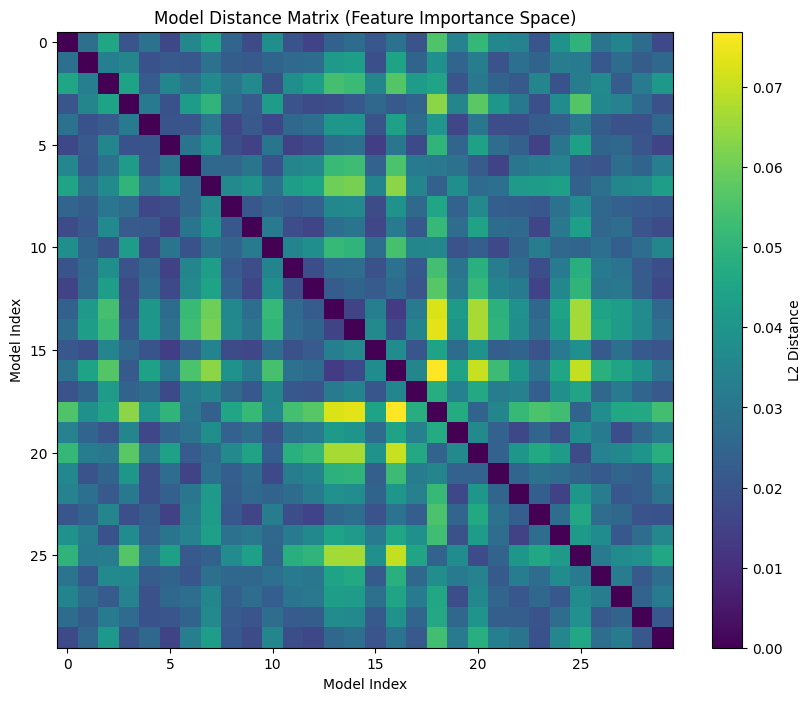

Model Distance Statistics:
Mean distance: 0.0320
Std distance: 0.0119
Max distance: 0.0769
Min distance: 0.0138


In [56]:
def compute_model_distance(model1_importances, model2_importances):
    """Compute L2 distance between two models based on feature importances"""
    return np.sqrt(np.sum((model1_importances - model2_importances) ** 2))


# Compute pairwise distances between bootstrap models
n_models = len(stability_matrix)
distance_matrix = np.zeros((n_models, n_models))

for i in range(n_models):
    for j in range(i + 1, n_models):
        dist = compute_model_distance(stability_matrix[i], stability_matrix[j])
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Visualize distance matrix
plt.figure(figsize=(10, 8))
plt.imshow(distance_matrix, cmap="viridis")
plt.colorbar(label="L2 Distance")
plt.title("Model Distance Matrix (Feature Importance Space)")
plt.xlabel("Model Index")
plt.ylabel("Model Index")
plt.show()

# Print distance statistics
upper_tri = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
print(f"Model Distance Statistics:")
print(f"Mean distance: {np.mean(upper_tri):.4f}")
print(f"Std distance: {np.std(upper_tri):.4f}")
print(f"Max distance: {np.max(upper_tri):.4f}")
print(f"Min distance: {np.min(upper_tri):.4f}")

In [57]:
# Create comprehensive stability report
print("=" * 60)
print("COMPREHENSIVE STABILITY ANALYSIS REPORT")
print("=" * 60)

print(f"\n1. MODEL PERFORMANCE:")
print(f"   Test Accuracy: {accuracy:.4f}")
print(f"   Test AUC: {auc_score:.4f}")

print(f"\n2. PERFORMANCE STABILITY:")
print(
    f"   Accuracy CV: {np.std(perf_stability['accuracy'])/np.mean(perf_stability['accuracy']):.4f}"
)
print(f"   AUC CV: {np.std(perf_stability['auc'])/np.mean(perf_stability['auc']):.4f}")

print(f"\n3. FEATURE IMPORTANCE STABILITY:")
most_stable_idx = np.argmin(stability_coefficient)
least_stable_idx = np.argmax(stability_coefficient)
print(
    f"   Most stable feature: {feature_names[most_stable_idx]} (CV: {stability_coefficient[most_stable_idx]:.4f})"
)
print(
    f"   Least stable feature: {feature_names[least_stable_idx]} (CV: {stability_coefficient[least_stable_idx]:.4f})"
)
print(f"   Mean stability CV: {np.mean(stability_coefficient):.4f}")

print(f"\n4. MODEL STRUCTURAL STABILITY:")
print(f"   Mean model distance: {np.mean(upper_tri):.4f}")
print(f"   Model distance CV: {np.std(upper_tri)/np.mean(upper_tri):.4f}")

COMPREHENSIVE STABILITY ANALYSIS REPORT

1. MODEL PERFORMANCE:
   Test Accuracy: 0.7423
   Test AUC: 0.7189

2. PERFORMANCE STABILITY:
   Accuracy CV: 0.0008
   AUC CV: 0.0012

3. FEATURE IMPORTANCE STABILITY:
   Most stable feature: delinq_2yrs_flag (CV: 0.0000)
   Least stable feature: emp_title_grouped_clerk (CV: 0.6530)
   Mean stability CV: 0.1619

4. MODEL STRUCTURAL STABILITY:
   Mean model distance: 0.0320
   Model distance CV: 0.3714


## STEP 4

In [58]:
X_total = df_clean[feature_cols]
y_total = df_clean["target"]

y_total_pred_proba = xgb_model.predict_proba(X_total)[:, 1]
y_total_pred = (y_total_pred_proba >= 0.3).astype(int)  # Apply 0.3 threshold

In [59]:
numerical = ['issue_d', 'loan duration', 'annual_inc', 'avg_cur_bal',
    'bc_open_to_buy', 'bc_util', 'delinq_2yrs', 'dti', 'fico_range_high', 'funded_amnt', 
    'inq_last_6mths', 'int_rate', 'mo_sin_old_rev_tl_op',
    'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
    'mths_since_recent_bc', 'num_actv_bc_tl', 'num_bc_tl', 'num_il_tl',
    'num_rev_accts', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
    'tax_liens', 'zip_code', 'Pct_afro_american', 'avg_cur_bal_log', 'revol_bal_log',
    'cur_balance', 's_actv_bc_tl', 's_bc_tl', 's_il_tl', 's_rev_accts', 'revol_bal_income_ratio',
    'sub_grade_num', 'emp_length_num']

numerical_existing = [col for col in numerical if col in X_total.columns]
X_standardized = X_total.copy().reset_index(drop=True)
X_standardized.loc[:, numerical_existing] = StandardScaler().fit_transform(X_standardized[numerical_existing])

### Logistic Regression

In [60]:
logreg = LogisticRegression(max_iter=3000)
logreg.fit(X_standardized, y_total_pred)
surrogate_preds_proba = logreg.predict_proba(X_standardized)[:, 1] #probs of 1
surrogate_preds = logreg.predict(X_standardized)

In [61]:
print_evaluation_metrics(y_total_pred, y_total_pred_proba, surrogate_preds, surrogate_preds_proba)

AUC: 0.8711050772762425
Accuracy score: 0.9186392275711723
Confusion matrix: [[803551  34729]
 [ 53648 194308]]
Mean squared error: 0.23674108905439403


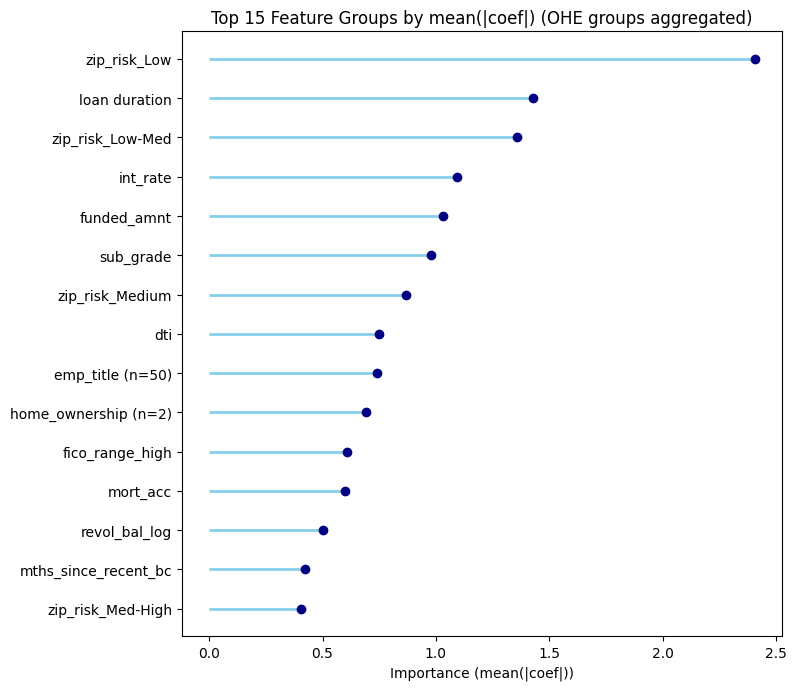

In [62]:
plot_most_important_features(logreg.coef_[0], X_standardized.columns)

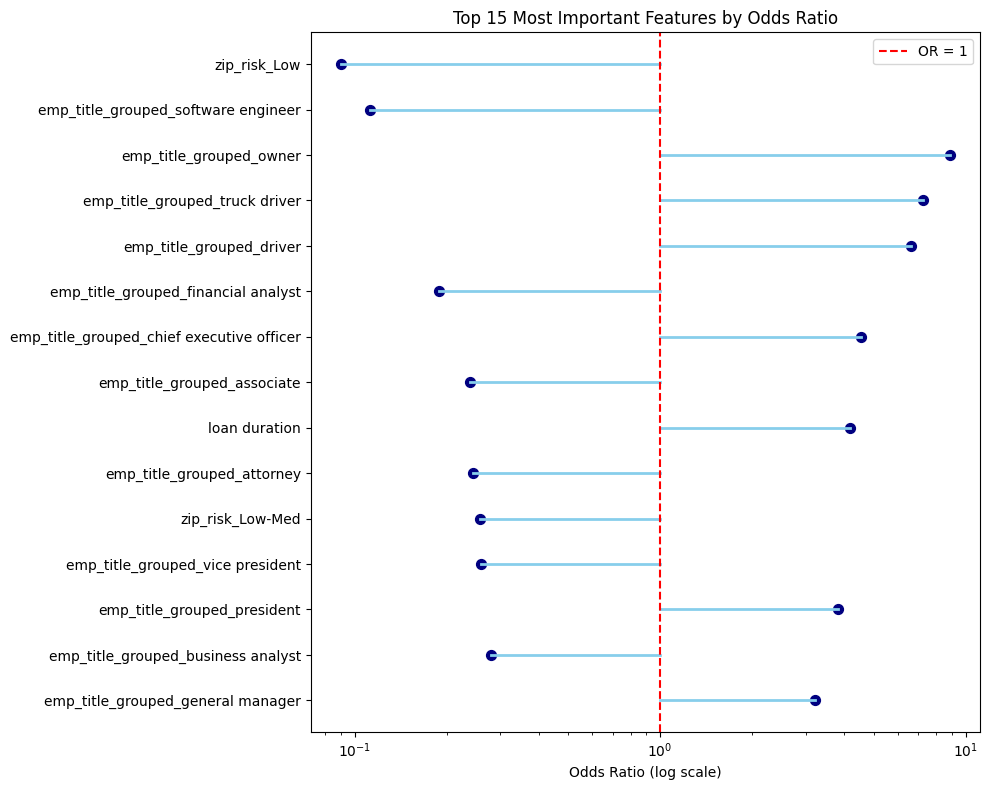

In [63]:
plot_odds_ratio(logreg.coef_[0], X_standardized.columns)

### Custom PLTR

In [64]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

pltr = PLTR(k=5, random_state=10, feature_names=X_standardized.columns)
pltr.fit(X_standardized, y_total_pred, adaptive_lasso=True)

,n_estimators,80
,max_depth,3
,random_state,10
,granularity,2
,k,5
,feature_names,"Index(['loan ...', length=104)"


In [65]:
pltr.modified_input_full

,loan duration,annual_inc,bc_open_to_buy,bc_util,delinq_2yrs,dti,fico_range_high,funded_amnt,inq_last_6mths,int_rate,...,emp_title_grouped_technician,emp_title_grouped_truck driver,emp_title_grouped_vice president,int_rate > 0.44,int_rate < 0.44xloan duration > 0.47,sub_grade_num > 0.48,sub_grade_num < 0.48xloan duration > 0.47,int_rate < 0.44xsub_grade_num > 0.01,int_rate < 0.44xsub_grade_num > 1.27,int_rate < 0.44xint_rate > -0.15
0,-0.818973,-0.213572,0.140004,-0.119452,-0.055413,-1.412203,1.303661,-1.209641,0.512971,-0.478131,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1,-0.818973,-0.133526,0.077884,-0.018263,-0.055413,0.398192,0.779836,1.209997,-0.244530,-0.478131,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2,-0.818973,1.139931,0.046501,0.017074,-0.055413,0.014438,1.094131,1.313308,0.134220,-1.041111,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
3,-0.818973,0.256307,-0.079592,0.086407,-0.055413,-0.475914,0.465542,-0.426657,0.134220,-0.311075,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
4,2.013511,-0.039966,-0.063900,0.037419,0.109117,0.421288,-0.582106,1.269809,0.134220,1.022035,...,0.0,0.0,0.0,1.376825,0.000000,0.025409,0.000000,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086231,2.013511,0.100374,0.109182,-0.124538,-0.055413,-0.894313,-0.163047,2.074543,0.134220,0.023038,...,0.0,0.0,0.0,0.000000,0.361801,0.000000,0.305665,0.671453,0.0,0.037982
1086232,2.013511,0.136758,0.131401,-0.092950,0.438178,-0.598502,-0.477342,0.878317,0.134220,1.693602,...,0.0,0.0,0.0,1.376825,0.000000,0.025409,0.000000,0.000000,0.0,0.000000
1086233,-0.818973,-0.081548,0.196925,-0.096698,0.109117,0.103270,0.675072,-0.644153,-0.244530,-0.979300,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1086234,-0.818973,-0.206295,-0.029760,-0.147828,0.109117,0.142356,-0.477342,-1.079144,-0.244530,-0.402956,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000


In [66]:
pltr_pred = pltr.predict(pltr.modified_input_full)
pltr_pred_prob = pltr.predict_proba(pltr.modified_input_full)[:, 1]

In [67]:
print_evaluation_metrics(y_total_pred, y_total_pred_proba, pltr_pred, pltr_pred_prob)

AUC: 0.8758618248648157
Accuracy score: 0.9196666286147762
Confusion matrix: [[801786  36494]
 [ 50767 197189]]
Mean squared error: 0.23752558076103866


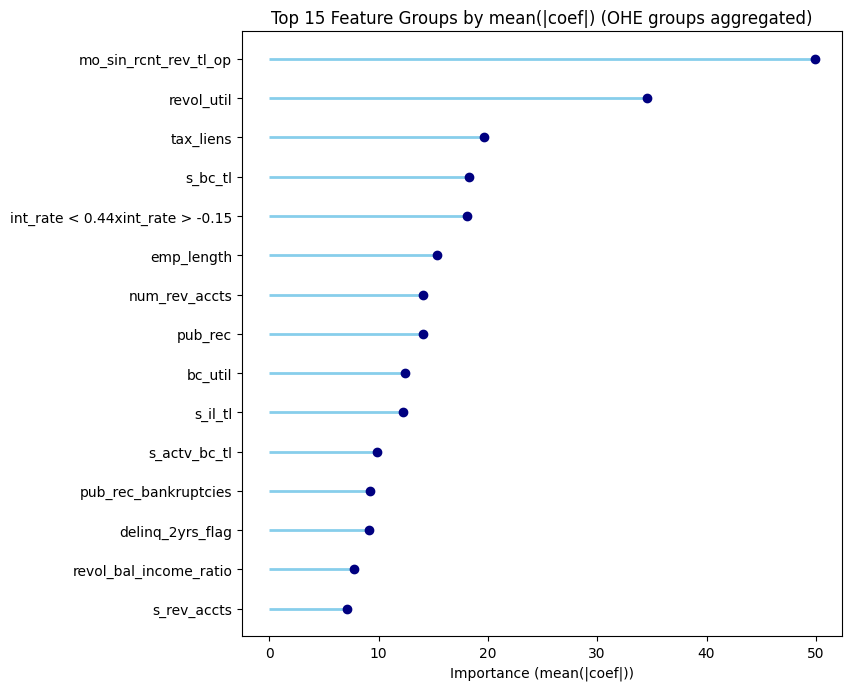

In [68]:
plot_most_important_features(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

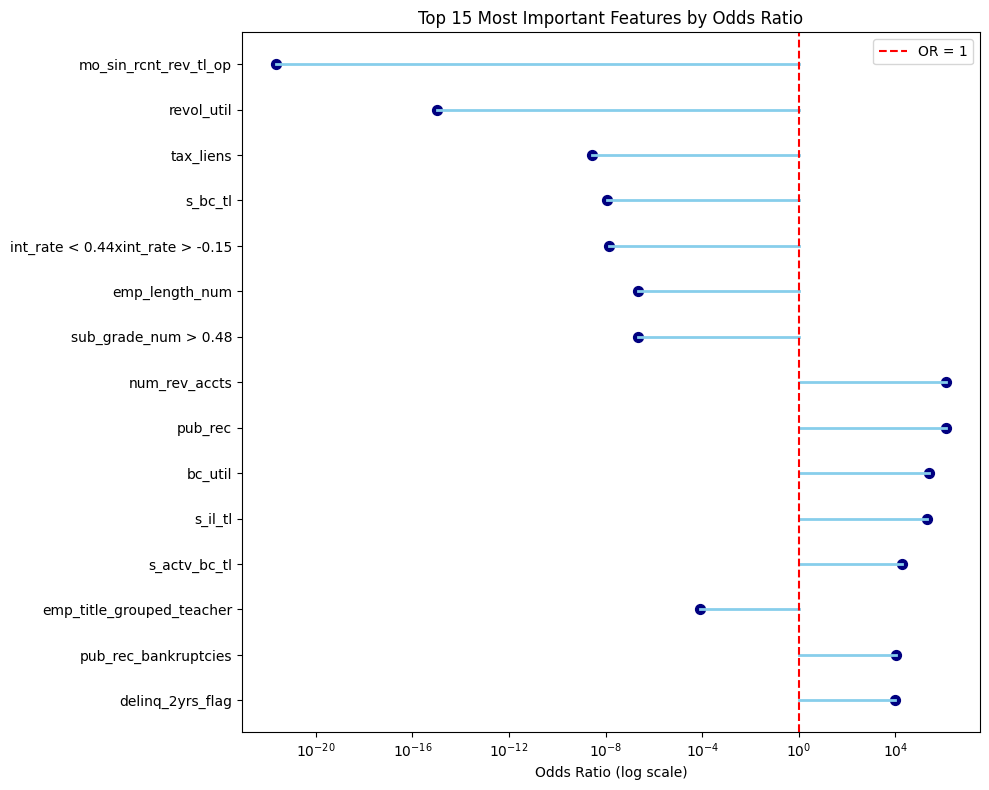

In [69]:
plot_odds_ratio(pltr.pltr.coef_[0] * pltr.weights_alasso, pltr.modified_input_full.columns)

Top 3 features by importance:

- Step1 x logistic regression: loan_duration, emp_title, home_ownership

- Step1 x PLTR: issue_d, emp_length, num_rev_accts

- Step4 x logistic regression: zip_risk_Low, loan_duration, zip_risk_Low-Med

- Step4 x PLTR: mo_sin_old_rev_tl_op, revol_util, tax_liens

Conclusions:

- Interoperability is limited: surrogates explain different black boxes with differing inputs (issue_d was not considered for step4) and encodings (Feature transformations).

- Only loan_duration shows consistent importance across both steps.

- Surrogate type differences (logistic vs tree) change interpretability.

- Different feature signals: Step1 surrogates highlight issue_d, emp_length, num_rev_accts, while Step4 surrogates highlight mo_sin_old_rev_tl_op, revol_util, tax_liens. Very little overlap that suggests different underlying drivers.

## STEP 5

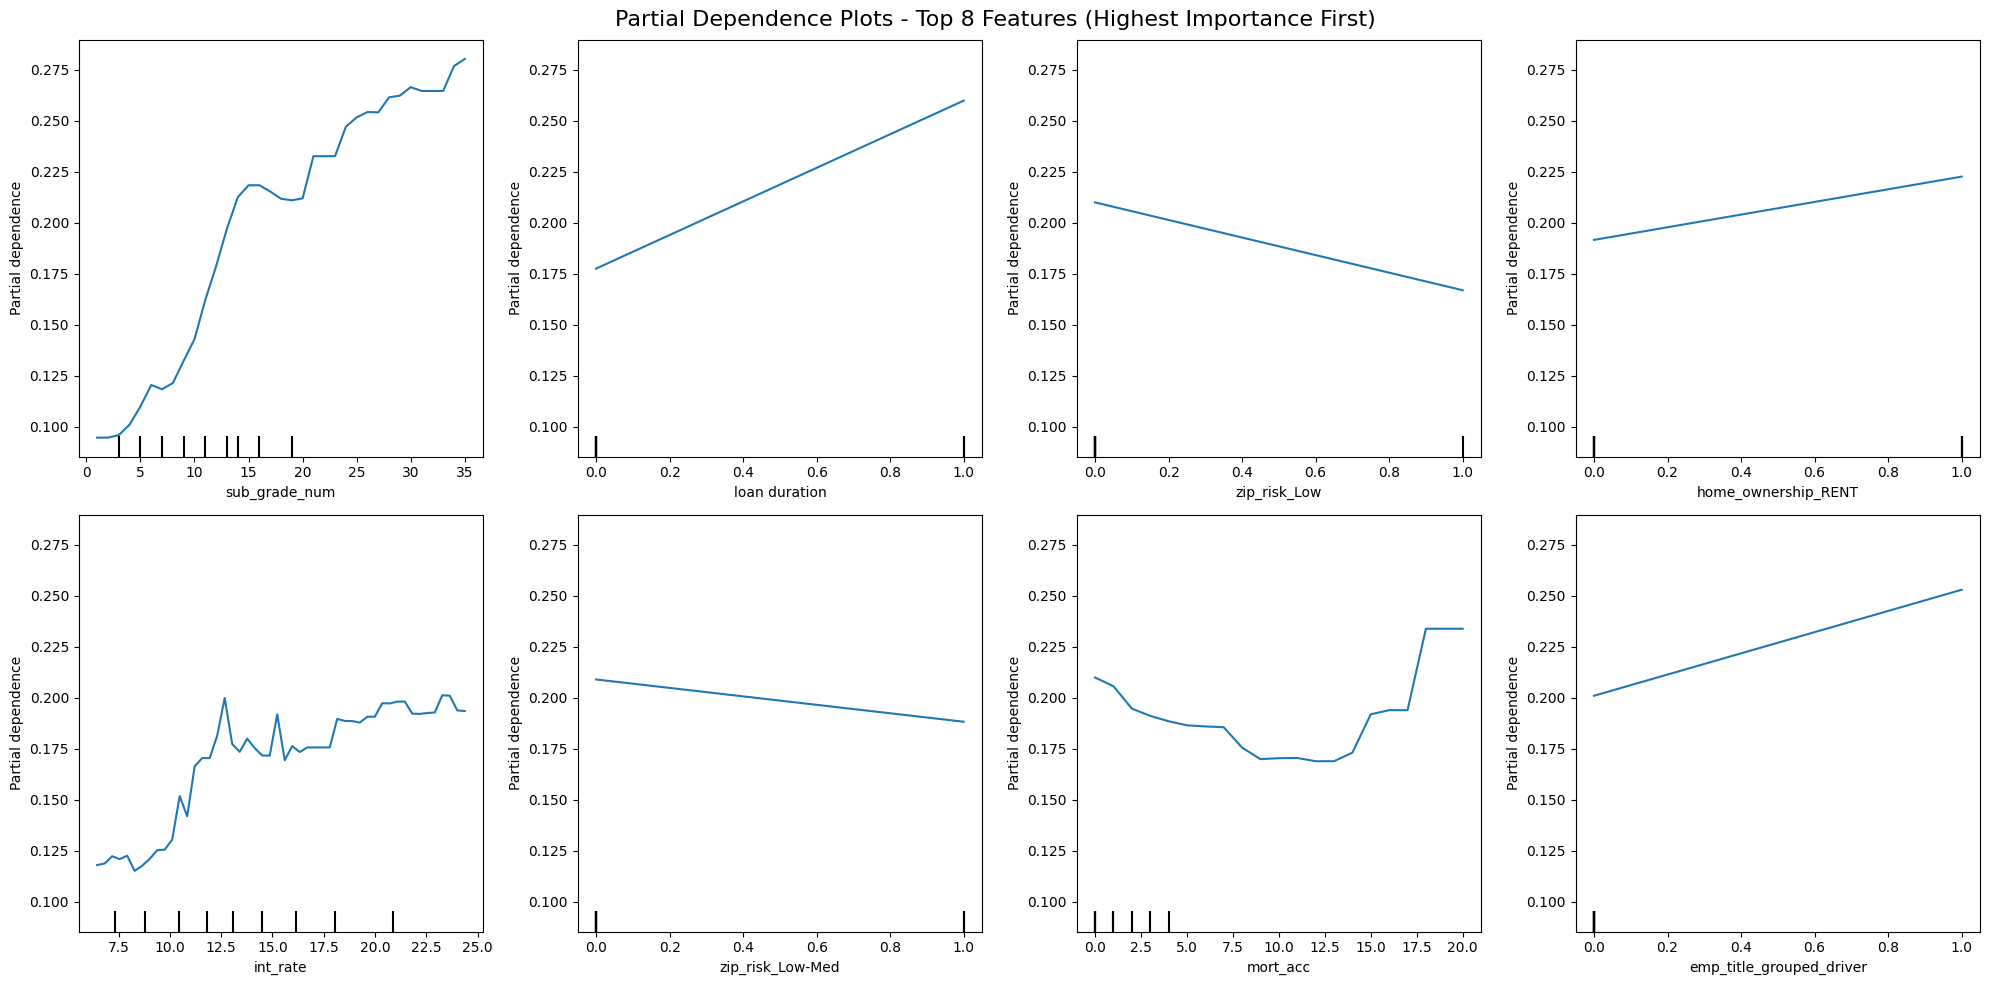

In [70]:
def create_partial_dependence_plots(model, X_test, n_features=8):
    """Create partial dependence plots for top N most important features"""

    feature_importance = model.feature_importances_
    feature_names = X_test.columns.tolist()

    # Get top N features - reverse to get highest importance first
    top_indices = np.argsort(feature_importance)[-n_features:][::-1]
    top_features = [feature_names[i] for i in top_indices]

    # Create plots
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))

    display = PartialDependenceDisplay.from_estimator(
        model,
        X_test,
        features=top_features,
        ax=axes.ravel(),
        n_jobs=-1,
        grid_resolution=50,
        random_state=42,
    )

    plt.suptitle(f"Partial Dependence Plots - Top {n_features} Features (Highest Importance First)", fontsize=16)
    plt.tight_layout()
    plt.show()

    return display, top_features

display, top_features = create_partial_dependence_plots(xgb_model, X_test, n_features=8)

# STEP 6

## ICE

In [71]:
# Get feature names and importance
feature_names = X_test.columns
feature_importance = xgb_model.feature_importances_

# Choose top 4 features
top_idx = np.argsort(feature_importance)[-4:]
features_to_plot = [feature_names[i] for i in top_idx]

print("Top 4 features for ICE analysis:")
for i, feat in enumerate(features_to_plot):
    print(f"{i+1}. {feat}: {feature_importance[top_idx[i]]:.4f}")


Top 4 features for ICE analysis:
1. home_ownership_RENT: 0.0292
2. zip_risk_Low: 0.0298
3. loan duration: 0.0726
4. sub_grade_num: 0.2927


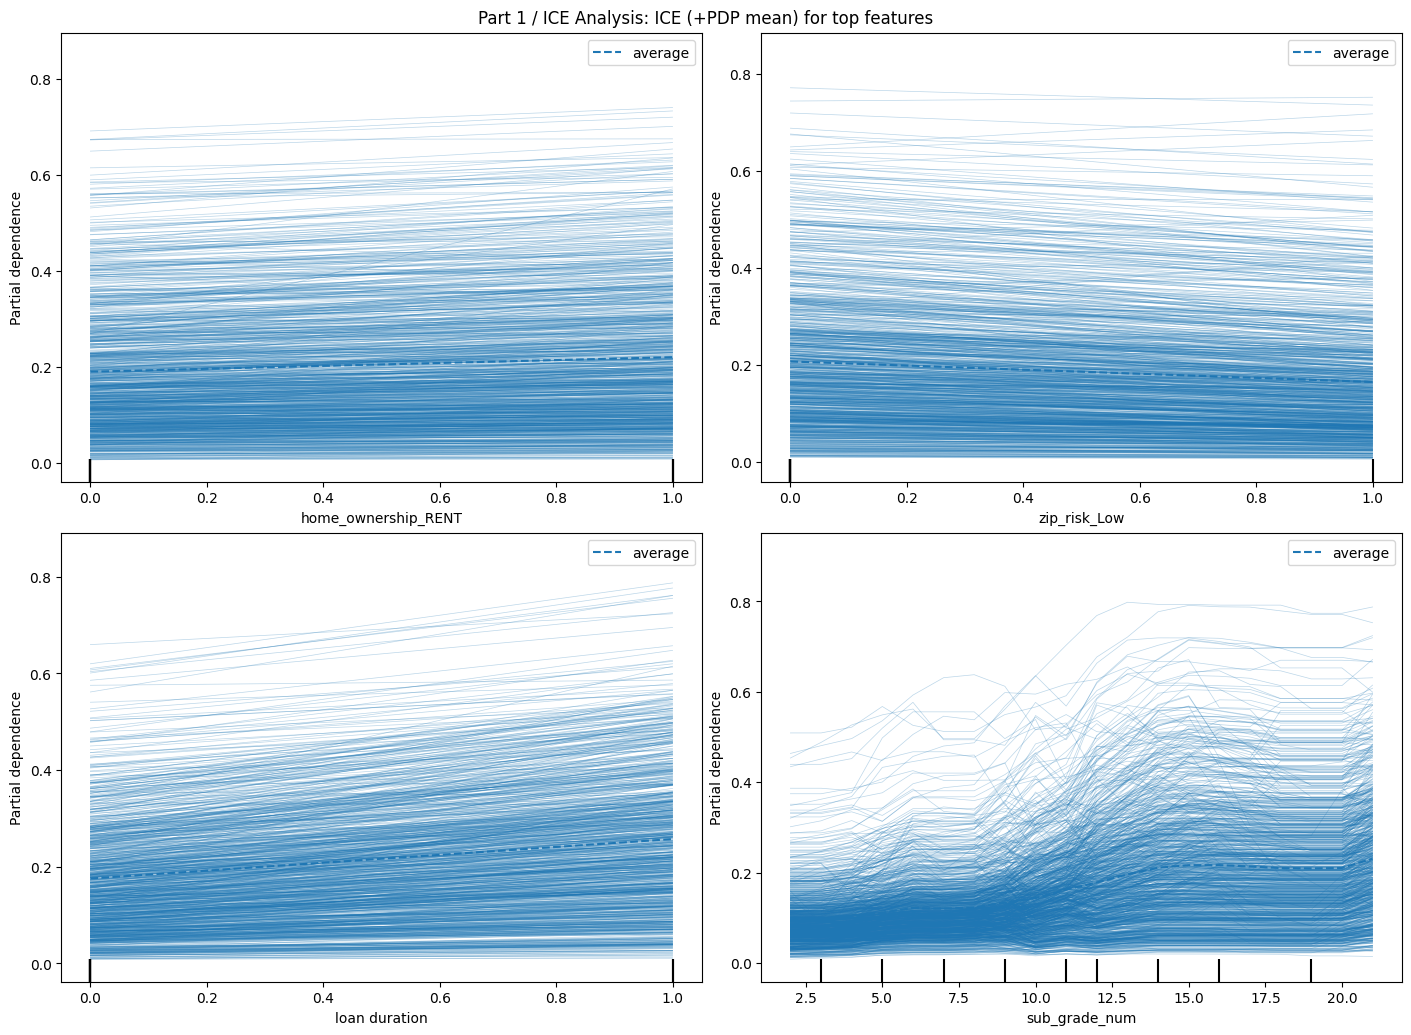

In [72]:
# ICE plots (subsample + PDP overlay)
# Subsample rows for speed
max_rows = 5000
X_ref = X_test.sample(n=max_rows, random_state=42) if len(X_test) > max_rows else X_test

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
axes = axes.ravel()

for ax, feat in zip(axes, features_to_plot):
    PartialDependenceDisplay.from_estimator(
        xgb_model,
        X_ref,
        features=[feat],
        kind='both',  # ICE + PDP mean
        ax=ax,
        feature_names=feature_names,
        grid_resolution=20,
    )
    ax.set_title(f"ICE + PDP — {feat}")

plt.suptitle('Part 1 / ICE Analysis: ICE (+PDP mean) for top features', y=1.02)
plt.show()


## LIME

In [73]:
# LIME explanations on representative test instances
# Use training distribution to fit the explainer
X_train_np = X_train.values if hasattr(X_train, 'values') else np.asarray(X_train)
X_test_np = X_test.values if hasattr(X_test, 'values') else np.asarray(X_test)

class_names = ['no_default', 'default']
feature_names_list = list(X_train.columns)

explainer = LimeTabularExplainer(
    training_data=X_train_np,
    mode='classification',
    feature_names=feature_names_list,
    class_names=class_names,
    discretize_continuous=True,
    sample_around_instance=True,
    verbose=False,
    random_state=42,
)

print("LIME explainer initialized successfully!")
print(f"Number of features: {len(feature_names_list)}")
print(f"Training samples: {X_train_np.shape[0]}")
print(f"Test samples: {X_test_np.shape[0]}")


LIME explainer initialized successfully!
Number of features: 104
Training samples: 856247
Test samples: 129091


In [74]:
# Pick representative instances to explain
# Select instances with different predicted probabilities
y_pred_proba = xgb_model.predict_proba(X_test_np)[:, 1]

# Find instances with different risk levels
low_risk_idx = np.where((y_pred_proba >= 0.1) & (y_pred_proba <= 0.3))[0][:1]  # Low risk
medium_risk_idx = np.where((y_pred_proba >= 0.4) & (y_pred_proba <= 0.6))[0][:1]  # Medium risk  
high_risk_idx = np.where((y_pred_proba >= 0.7) & (y_pred_proba <= 0.9))[0][:1]  # High risk

indices_to_explain = np.concatenate([low_risk_idx, medium_risk_idx, high_risk_idx])

print("Selected instances for LIME analysis:")
for i, idx in enumerate(indices_to_explain):
    actual_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    pred_proba = y_pred_proba[idx]
    print(f"Instance {i+1} (Index {idx}): Predicted probability = {pred_proba:.3f}, Actual label = {actual_label}")


Selected instances for LIME analysis:
Instance 1 (Index 1): Predicted probability = 0.168, Actual label = 0
Instance 2 (Index 2): Predicted probability = 0.410, Actual label = 0
Instance 3 (Index 673): Predicted probability = 0.834, Actual label = 1


In [75]:
# Generate LIME explanations
def predict_fn(data):
    """Prediction function for LIME"""
    return xgb_model.predict_proba(data)

lime_results = []
for idx in indices_to_explain:
    instance = X_test_np[idx]
    exp = explainer.explain_instance(
        data_row=instance,
        predict_fn=predict_fn,
        num_features=10,  # Top 10 features
        top_labels=2,     # Both classes
    )
    lime_results.append((idx, exp))

print("LIME explanations generated successfully!")
print(f"Analyzed {len(lime_results)} instances")


LIME explanations generated successfully!
Analyzed 3 instances


In [76]:
# Display LIME explanations
for i, (idx, exp) in enumerate(lime_results):
    actual_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    pred_proba = y_pred_proba[idx]
    
    print(f"\n{'='*60}")
    print(f"LIME EXPLANATION - Instance {i+1} (Index {idx})")
    print(f"{'='*60}")
    print(f"Predicted probability of default: {pred_proba:.3f}")
    print(f"Actual label: {'Default' if actual_label == 1 else 'No Default'}")
    print(f"Prediction: {'High Risk' if pred_proba > 0.5 else 'Low Risk'}")
    
    # Get explanation for the predicted class
    predicted_class = 1 if pred_proba > 0.5 else 0
    explanation = exp.as_list(label=predicted_class)
    
    print(f"\nTop 10 features contributing to prediction:")
    print("-" * 50)
    for feature, weight in explanation:
        print(f"{feature:<30} {weight:>8.4f}")
    
    print(f"\nFeature values for this instance:")
    print("-" * 50)
    instance_data = X_test.iloc[idx] if hasattr(X_test, 'iloc') else pd.Series(X_test_np[idx], index=feature_names_list)
    for feature, _ in explanation[:5]:  # Show top 5 features
        if feature in instance_data.index:
            print(f"{feature:<30} {instance_data[feature]:>8.4f}")



LIME EXPLANATION - Instance 1 (Index 1)
Predicted probability of default: 0.168
Actual label: No Default
Prediction: Low Risk

Top 10 features contributing to prediction:
--------------------------------------------------
loan duration <= 0.00            0.0825
emp_title_grouped_owner <= 0.00   0.0720
emp_title_grouped_chief executive officer <= 0.00   0.0619
emp_title_grouped_driver <= 0.00   0.0595
funded_amnt <= 8000.00           0.0549
emp_title_grouped_truck driver <= 0.00   0.0528
purpose_renewable_energy <= 0.00  -0.0472
emp_title_grouped_business analyst <= 0.00  -0.0453
emp_title_grouped_software engineer <= 0.00  -0.0436
purpose_small_business <= 0.00   0.0352

Feature values for this instance:
--------------------------------------------------

LIME EXPLANATION - Instance 2 (Index 2)
Predicted probability of default: 0.410
Actual label: No Default
Prediction: Low Risk

Top 10 features contributing to prediction:
--------------------------------------------------
emp_title_g

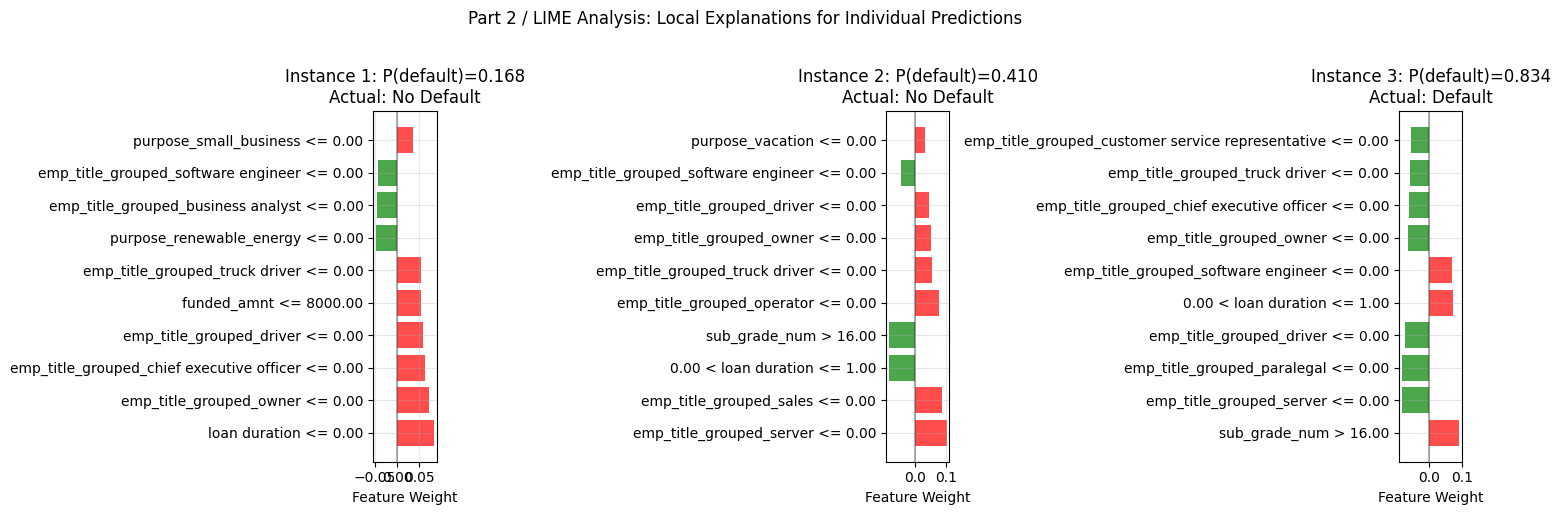

In [77]:
# Visualize LIME explanations
fig, axes = plt.subplots(1, len(lime_results), figsize=(15, 5))
if len(lime_results) == 1:
    axes = [axes]

for i, (idx, exp) in enumerate(lime_results):
    actual_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    pred_proba = y_pred_proba[idx]
    predicted_class = 1 if pred_proba > 0.5 else 0
    
    # Create LIME plot manually
    explanation = exp.as_list(label=predicted_class)
    
    # Extract features and weights
    features = [x[0] for x in explanation]
    weights = [x[1] for x in explanation]
    
    # Create horizontal bar plot
    y_pos = np.arange(len(features))
    colors = ['red' if w > 0 else 'green' for w in weights]
    
    axes[i].barh(y_pos, weights, color=colors, alpha=0.7)
    axes[i].set_yticks(y_pos)
    axes[i].set_yticklabels(features)
    axes[i].set_xlabel('Feature Weight')
    axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
    axes[i].set_title(f'Instance {i+1}: P(default)={pred_proba:.3f}\nActual: {"Default" if actual_label==1 else "No Default"}')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Part 2 / LIME Analysis: Local Explanations for Individual Predictions', y=1.02)
plt.tight_layout()
plt.show()


## STEP 7

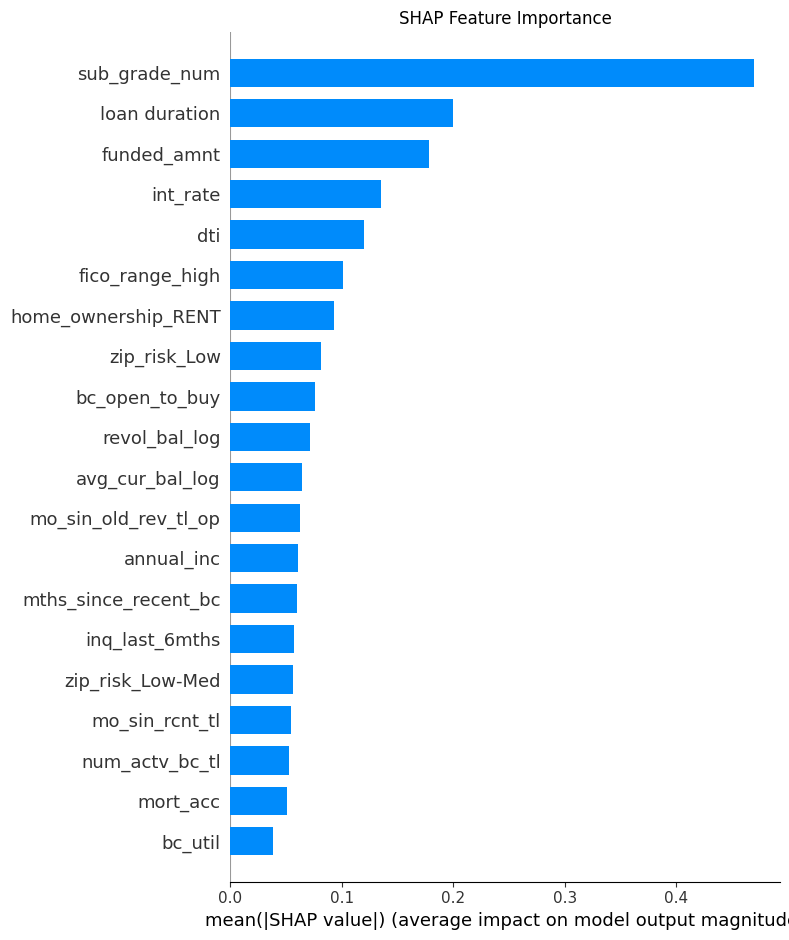

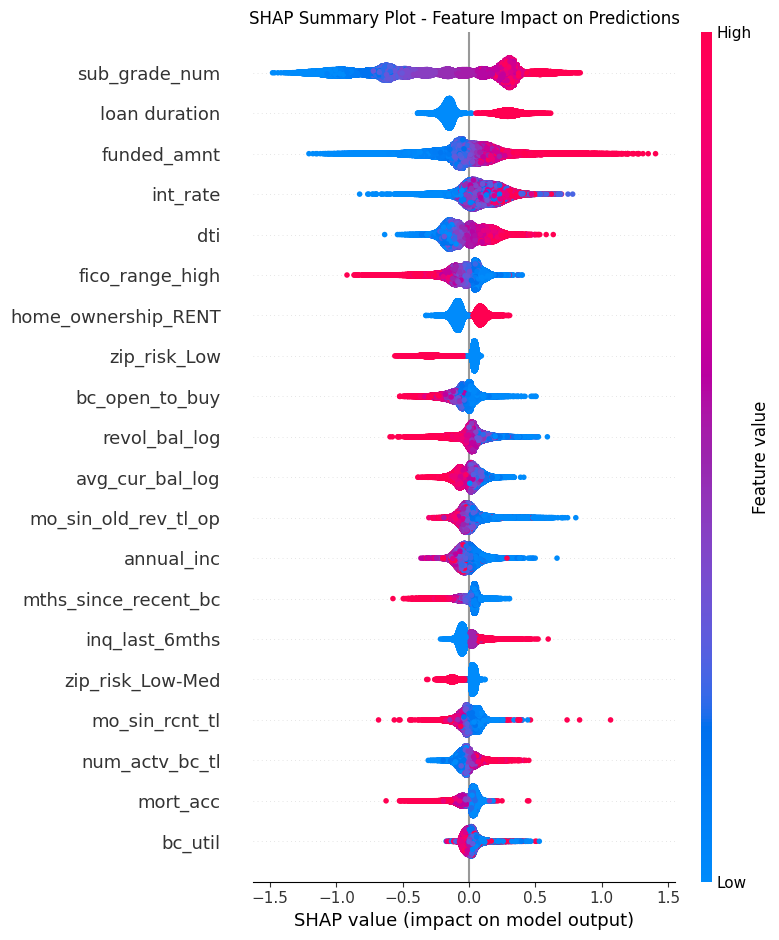

In [78]:
import shap

# Initialize SHAP explainer for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

shap_values = np.array(shap_values, dtype=float)

# 1. SHAP Summary Plot (beeswarm/dot plot)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Predictions")
plt.tight_layout()
plt.show()

<Figure size 1000x800 with 0 Axes>

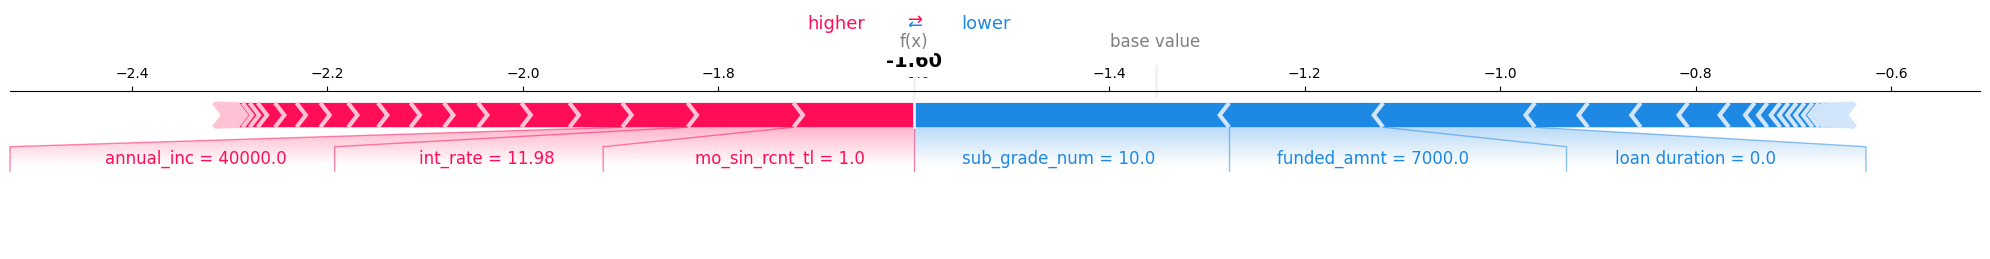

<Figure size 1000x800 with 0 Axes>

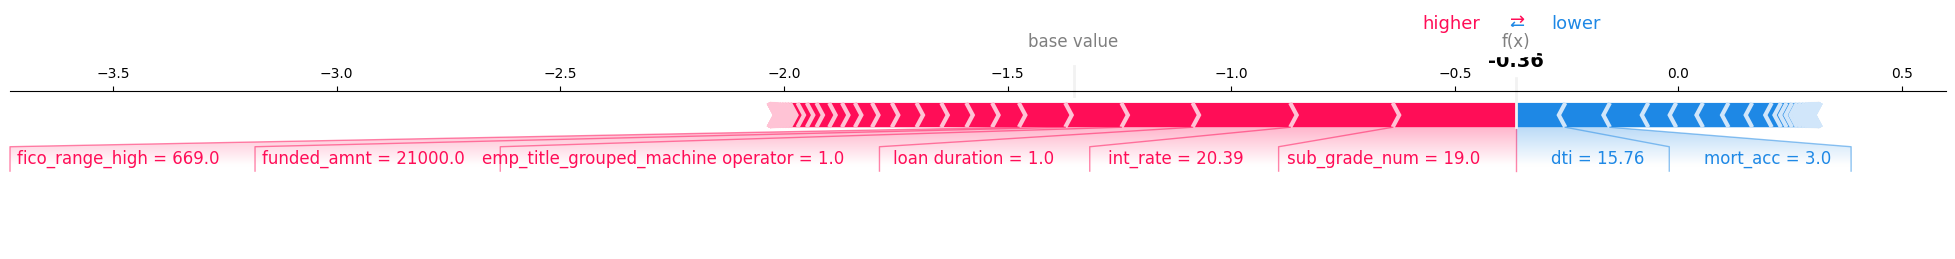

<Figure size 1000x800 with 0 Axes>

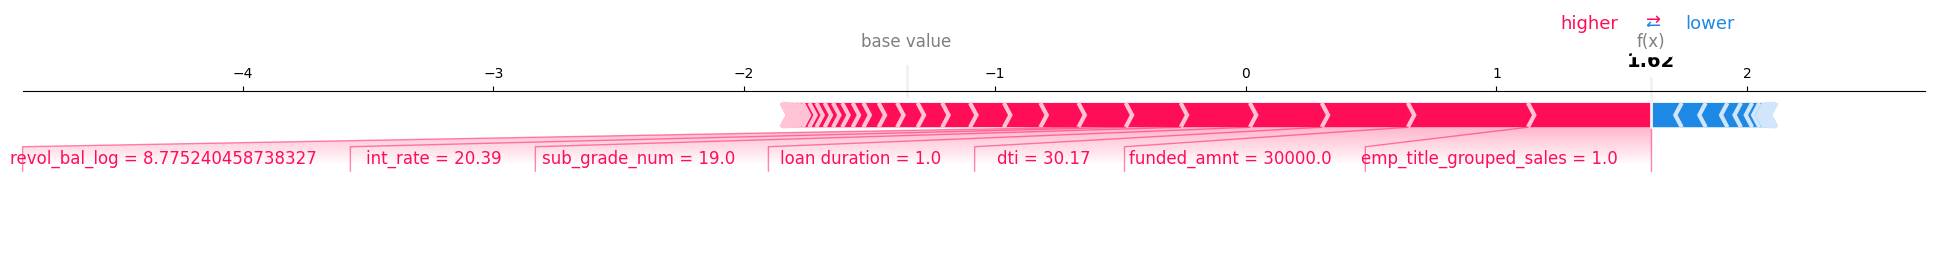

In [79]:
# Reuse the LIME-selected instances
for sample_idx in indices_to_explain:
    plt.figure(figsize=(10, 8))
    shap.force_plot(
        explainer.expected_value,
        shap_values[sample_idx],
        X_test.iloc[sample_idx],
        matplotlib=True,
        show=False,
    )
    plt.title("")
    plt.tight_layout()
    plt.show()


# Step 8

In [80]:
from sklearn.metrics import make_scorer, roc_auc_score

auc_scorer = make_scorer(roc_auc_score)

In [81]:
from sklearn.inspection import permutation_importance
r = permutation_importance(
  xgb_model,
  X_test,
  y_test,
  n_repeats=5,
  scoring=auc_scorer,
  random_state=42
)

In [82]:
importances_mean = r.importances_mean
importances_std = r.importances_std

significant_mask = importances_mean - 2 * importances_std > 0
sorted_indices = importances_mean.argsort()[::-1]

for rank, i in enumerate(sorted_indices, 1):
    if significant_mask[i]:
        feature_name = X_test.columns[i]
        importance = importances_mean[i]
        std_dev = importances_std[i]
        print(f"{rank:2d}. {feature_name:<30} {importance:.4f} ± {std_dev:.4f}")

feat_names = X_test.columns
imp_df = (
    pd.DataFrame({
        "feature": feat_names, 
        "mean_drop_auc": importances_mean, 
        "std": importances_std
    })
    .sort_values("mean_drop_auc", ascending=False)
    .reset_index(drop=True)
)

 1. sub_grade_num                  0.0224 ± 0.0009
 2. int_rate                       0.0192 ± 0.0008
 3. loan duration                  0.0109 ± 0.0004
 4. funded_amnt                    0.0044 ± 0.0006
 5. mort_acc                       0.0035 ± 0.0002
 6. home_ownership_RENT            0.0024 ± 0.0003
 7. fico_range_high                0.0023 ± 0.0002
 8. avg_cur_bal_log                0.0013 ± 0.0003
 9. inq_last_6mths                 0.0012 ± 0.0003
10. mths_since_recent_bc           0.0009 ± 0.0001
11. mo_sin_old_rev_tl_op           0.0008 ± 0.0002
12. emp_title_grouped_owner        0.0007 ± 0.0001
14. s_il_tl                        0.0006 ± 0.0002
15. emp_title_grouped_driver       0.0005 ± 0.0001
16. emp_title_grouped_manager      0.0004 ± 0.0001
19. emp_title_grouped_truck driver 0.0002 ± 0.0001
20. purpose_small_business         0.0002 ± 0.0000
21. purpose_major_purchase         0.0002 ± 0.0000
25. emp_title_grouped_business analyst 0.0001 ± 0.0000
26. emp_title_grouped_sales

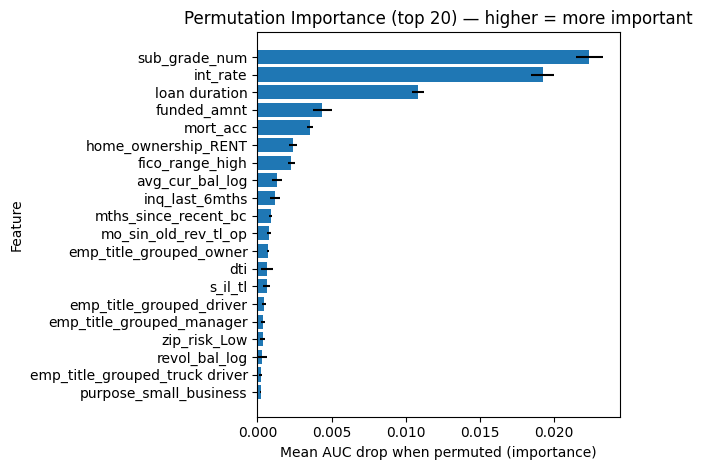

In [83]:
TOP_K = 20
top = imp_df.head(TOP_K).iloc[::-1]

plt.figure()
plt.barh(top["feature"], top["mean_drop_auc"], xerr=top["std"])
plt.xlabel("Mean AUC drop when permuted (importance)")
plt.ylabel("Feature")
plt.title(f"Permutation Importance (top {TOP_K}) — higher = more important")
plt.tight_layout()
plt.show()

# STEP 9

In [ ]:
# === Predictions with tuned threshold ===
test_proba = xgb_model.predict_proba(X_test)[:, 1]
y_pred = (test_proba >= 0.3).astype(int)

# === Build fairness dataframe aligned with X_test ===
fairness_df = X_test.copy()
fairness_df["y_true"] = y_test
fairness_df["y_pred"] = y_pred

# Add protected + control attributes from the parallel engineered dataframe
fairness_df["Pct_afro_american"] = df_original_for_fairness.loc[X_test.index, "Pct_afro_american"]
fairness_df["annual_inc"] = df_original_for_fairness.loc[X_test.index, "annual_inc"]
fairness_df["fico_range_high"] = df_original_for_fairness.loc[X_test.index, "fico_range_high"]
fairness_df["grade"] = df_original_for_fairness.loc[X_test.index, "grade"]
fairness_df["loan_duration"] = df_original_for_fairness.loc[X_test.index, "loan duration"]

# === Median split into High vs. Low group ===
median_val = fairness_df["Pct_afro_american"].median()
fairness_df["ethnicity_group"] = np.where(
    fairness_df["Pct_afro_american"] > median_val, "High", "Low"
)

print("Fairness dataframe ready:", fairness_df.shape)
print(fairness_df[["y_true", "y_pred", "Pct_afro_american", "ethnicity_group"]].head())




# === 1. Statistical Parity (Demographic Parity) ===
dp = fairness_df.groupby("ethnicity_group")["y_pred"].mean()
print("\nDemographic parity (selection rate):\n", dp)

# === 2. Conditional Statistical Parity (stratified) ===
def conditional_stat_parity_stratified(
    df,
    group_col="ethnicity_group",
    cond_spec={"annual_inc": "q4", "fico_range_high": "q4", "grade": "cat", "loan_duration": "cat"},
    yhat_col="y_pred",
):
    work = df[[group_col, yhat_col] + list(cond_spec.keys())].copy()

    # Bin continuous variables, cast categoricals
    for col, spec in cond_spec.items():
        if spec.startswith("q"):  # e.g. "q4" for quartiles
            q = int(spec[1:])
            work[col] = pd.qcut(work[col], q=q, duplicates="drop")
        elif spec == "cat":
            work[col] = work[col].astype("category")
        else:
            raise ValueError(f"Unknown spec for {col}: {spec}")

    # Selection rate within each stratum and group
    rates = (
        work.groupby(list(cond_spec.keys()) + [group_col])[yhat_col]
            .mean()
            .unstack(group_col)
    )

    # Keep only strata where both groups are present
    rates = rates.dropna()

    # Per-stratum gap and ratio
    gaps = (rates.max(axis=1) - rates.min(axis=1)).rename("gap")
    ratios = (rates.min(axis=1) / rates.max(axis=1)).rename("ratio")

    # Stratum weights (number of samples per stratum)
    weights = work.groupby(list(cond_spec.keys())).size().reindex(gaps.index).rename("n")

    # Weighted gap (always valid)
    w_gap = np.average(gaps.values, weights=weights.values)

    # Weighted ratio (only valid strata, drop NaNs)
    valid_ratios = ratios.dropna()
    if not valid_ratios.empty:
        w_ratio = np.average(valid_ratios.values, weights=weights.loc[valid_ratios.index].values)
    else:
        w_ratio = np.nan

    summary = pd.DataFrame({
        "n": weights,
        "gap": gaps,
        "ratio": ratios
    }).sort_values("n", ascending=False)

    return w_gap, w_ratio, rates, summary

w_gap, w_ratio, rate_table, per_stratum = conditional_stat_parity_stratified(
    fairness_df,
    group_col="ethnicity_group",
    cond_spec={"annual_inc": "q4", "fico_range_high": "q4", "grade": "cat", "loan_duration": "cat"},
    yhat_col="y_pred"
)

print("\n=== Conditional Statistical Parity ===")
print(f"Weighted gap (max-min across strata): {w_gap:.4f}")
print(f"Weighted ratio (valid strata only): {w_ratio:.3f}")

# === 3. Equal Opportunity (True Positive Rate per group) ===
def tpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tp / (tp + fn) if (tp + fn) > 0 else float("nan")

tpr_values = fairness_df.groupby("ethnicity_group").apply(
    lambda g: tpr(g["y_true"], g["y_pred"])
)
print("\nTrue positive rate (Equal opportunity):\n", tpr_values)

# === 4. False Positive Rate per group ===
def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return fp / (fp + tn) if (fp + tn) > 0 else float("nan")

fpr_values = fairness_df.groupby("ethnicity_group").apply(
    lambda g: fpr(g["y_true"], g["y_pred"])
)
print("\nFalse positive rate (Equalized odds):\n", fpr_values)

# === 5. Predictive Parity (Precision per group) ===
prec_values = fairness_df.groupby("ethnicity_group").apply(
    lambda g: precision_score(g["y_true"], g["y_pred"], zero_division=0)
)
print("\nPrecision (Predictive parity):\n", prec_values)

# === Build summary table ===
fairness_summary = pd.DataFrame({
    "Statistical Parity (DP)": dp,
    "Equal Opportunity (TPR)": tpr_values,
    "Equalized Odds (FPR)": fpr_values,
    "Predictive Parity (Precision)": prec_values
})

# Compute gaps and ratios
gaps = fairness_summary.max() - fairness_summary.min()
ratios = fairness_summary.min() / fairness_summary.max()

print("\n=== Fairness Metrics by Group ===")
print(fairness_summary.round(4))
print("\n=== Disparities (across groups) ===")
print(pd.DataFrame({"Gap (max-min)": gaps.round(4), "Ratio (min/max)": ratios.round(3)}))


Fairness dataframe ready: (129091, 110)
        y_true  y_pred  Pct_afro_american ethnicity_group
174322       0       1          34.973541            High
174323       0       0           5.169522             Low
174324       0       1          13.572137            High
174325       0       0           2.719069             Low
174326       0       0           7.542862             Low

Demographic parity (selection rate):
 ethnicity_group
High    0.235174
Low     0.201868
Name: y_pred, dtype: float64

=== Conditional Statistical Parity ===
Weighted gap (max-min across strata): 0.0303
Weighted ratio (valid strata only): 0.728

True positive rate (Equal opportunity):
 ethnicity_group
High    0.434032
Low     0.395125
dtype: float64

False positive rate (Equalized odds):
 ethnicity_group
High    0.170248
Low     0.147614
dtype: float64

Precision (Predictive parity):
 ethnicity_group
High    0.454258
Low     0.429043
dtype: float64

=== Fairness Metrics by Group ===
                 Stati

# STEP 10

In [85]:
# === Build test set with predictions + protected attribute ===
testset_fair = X_test.copy()

# Add model predictions
test_proba = xgb_model.predict_proba(X_test)[:, 1]
testset_fair["y_pred"] = (test_proba >= 0.3).astype(int)
testset_fair["y_actual"] = y_test

# Add protected attribute from the engineered full df
testset_fair["Pct_afro_american"] = df_original_for_fairness.loc[X_test.index, "Pct_afro_american"]

# Median split into High vs. Low
median_val = testset_fair["Pct_afro_american"].median()
testset_fair["afroamerican_share_class"] = np.where(
    testset_fair["Pct_afro_american"] > median_val, "High", "Low"
)

In [86]:
def fairness_test(df: pd.DataFrame,
                  prediction_col: str,
                  protected_col: str,
                  protected_type: str = "categorical") -> float:
    """
    Test dependence between categorical predictions (0/1) and protected attribute.

    Args:
        df: DataFrame with columns prediction_col and protected_col
        prediction_col: str, binary predictions (0/1)
        protected_col: str, attribute to test against
        protected_type: "categorical" or "continuous"

    Returns:
        p-value (float)
    """
    preds = df[prediction_col]
    prot  = df.loc[preds.index, protected_col]

    # case A: categorical protected
    if protected_type == "categorical":
        contingency = pd.crosstab(preds, prot)
        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            return float("nan")
        try:
            _, p, _, _ = stats.chi2_contingency(contingency, correction=False)
        except Exception:
            p = float("nan")
        return float(p)

    # case B: continuous protected
    elif protected_type == "continuous":
        # point-biserial correlation == pearson(preds, prot)
        try:
            _, p = stats.pearsonr(preds, prot)
        except Exception:
            p = float("nan")
        return float(p)

    else:
        raise ValueError("protected_type must be 'categorical' or 'continuous'")



def fpdp(
    df: pd.DataFrame,
    model,
    protected_col: str,
    protected_type: str,       # "categorical" or "continuous"
    features: list,
    threshold: float = 0.3,
    n_points: int = 15
):
    """
    Fair Partial Dependence Plot (FPDP) for multiple features.
    Returns a list of matplotlib Figures, one per feature.

    For each feature value (categories or grid for numeric):
      - overwrite that feature with fixed value
      - recompute predictions with the given model
      - run fairness_test on predictions vs protected attribute
    """
    figs = []
    feature_cols = [c for c in df.columns if c not in [protected_col, "target"]]

    for feat in features:
        series = df[feat]

        if pd.api.types.is_bool_dtype(series):
            # treat booleans like categorical
            grid = [0, 1]

        elif pd.api.types.is_numeric_dtype(series):
            grid = np.linspace(series.quantile(0.05),
                            series.quantile(0.95),
                            n_points)
        else:
            grid = series.dropna().unique()

        pvals = []
        for val in grid:
            X_mod = df.copy()
            X_mod[feat] = val

            X_input = X_mod[feature_cols].drop(columns=[protected_col], errors="ignore")
            proba = model.predict_proba(X_input)[:, 1]
            preds = (proba >= threshold).astype(int)

            X_mod["_fpdp_pred"] = preds

            pval = fairness_test(
                X_mod,
                prediction_col="_fpdp_pred",
                protected_col=protected_col,
                protected_type=protected_type
            )
            pvals.append(pval)

        # plot
        fig, ax = plt.subplots(figsize=(5, 3))
        if pd.api.types.is_numeric_dtype(df[feat]):
            ax.plot(grid, pvals, marker="o")
        else:
            ax.bar(grid, pvals)

        ax.axhline(0.05, color="red", linestyle="--", linewidth=1)
        ax.set_title(f"FPDP for {feat}")
        ax.set_ylabel("p-value")
        ax.set_xlabel(feat)
        plt.tight_layout()
        plt.show()
        figs.append(fig)
        

    return figs


In [87]:
testset_fair.drop(columns=["y_pred", "y_actual", "Pct_afro_american"], inplace=True)

# figs = fpdp(
#     testset_fair,
#     model=xgb_model,
#     protected_col="afroamerican_share_class",
#     protected_type="categorical",
#     features=list(testset_fair.drop(columns="afroamerican_share_class").columns)
# )
